In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import libraries
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import os
import numpy as np
import pandas as pd
import math, random
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_style('whitegrid')
from scipy import stats
import missingno as msno

# display all columns
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_row', None)

In [ ]:
# load data
train_data = pd.read_csv('/content/drive/MyDrive/최종프로젝트/physionet2012_train.csv')
valid_data = pd.read_csv('/content/drive/MyDrive/최종프로젝트/physionet2012_valid.csv')
test_data = pd.read_csv('/content/drive/MyDrive/최종프로젝트/physionet2012_test.csv')

train_data.drop(['Unnamed: 0'], axis=1, inplace=True)
valid_data.drop(['Unnamed: 0'], axis=1, inplace=True)
test_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
# labeling
# train_data
train_data['label'] = 0
train_data.loc[(2 <= train_data['survival'])&(train_data['survival'] <= train_data['LOS']), 'label'] = 1
train_data.loc[train_data['survival'] > train_data['LOS'], 'label'] = 0
train_data.loc[train_data['survival'] == -1, 'label'] = 0

# valid_data
valid_data['label'] = 0
valid_data.loc[(2 <= valid_data['survival'])&(valid_data['survival'] <= valid_data['LOS']), 'label'] = 1
valid_data.loc[valid_data['survival'] > valid_data['LOS'], 'label'] = 0
valid_data.loc[valid_data['survival'] == -1, 'label'] = 0

# test_data
test_data['label'] = 0
test_data.loc[(2 <= test_data['survival'])&(test_data['survival'] <= test_data['LOS']), 'label'] = 1
test_data.loc[test_data['survival'] > test_data['LOS'], 'label'] = 0
test_data.loc[test_data['survival'] == -1, 'label'] = 0

In [ ]:
train_df = train_data.copy()
valid_df = valid_data.copy()
test_df = test_data.copy()

In [ ]:
# ffill
train_df.groupby(['pid']).fillna(method='ffill', inplace=True)
valid_df.groupby(['pid']).fillna(method='ffill', inplace=True)
test_df.groupby(['pid']).fillna(method='ffill', inplace=True)

# median
train_df.fillna(train_df.median(), inplace=True)
valid_df.fillna(valid_df.median(), inplace=True)
test_df.fillna(test_df.median(), inplace=True)

In [ ]:
# Gender -1값 1로 바꾸기
train_df.loc[train_df['Gender']==-1, 'Gender'] = 1 

In [ ]:
n_cols = [x for x in train_df.columns if x not in ['pid', 'Gender', 'ICUType', 'MechVent', 'rec_time', 'Tropl', 'TropT', 'male', 'female', 'survival', 'surv_los', 'LOS', 'label']]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_df[n_cols])
scaled_train = scaler.transform(train_df[n_cols])
scaled_valid = scaler.transform(valid_df[n_cols])
scaled_test = scaler.transform(test_df[n_cols])
# scaled_train_df = pd.DataFrame(data=scaled_train, columns=ordinary_train.feature_names)

In [ ]:
train_df2 = train_df.copy()
valid_df2 = valid_df.copy()
test_df2 = test_df.copy()

In [ ]:
train_df2[n_cols] = scaled_train
valid_df2[n_cols] = scaled_valid
test_df2[n_cols] = scaled_test

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def get_padded_df(df):
    padded_df = []
    p = df['pid'].unique()
    max_len = 70
    for ep in tqdm(p):
        if len(df[df['pid']==ep]) >= max_len:
            ep_df = df[df['pid']==ep][:max_len]
            padded_df.append(ep_df)
        else:
            empty_df = pd.DataFrame(index=range(0,70), columns = df.columns) 
            empty_df[['pid']] = ep
            empty_df[['age']] = df[df['pid']==ep]['age'].values[0]
            empty_df[['Gender']] = df[df['pid']==ep]['Gender'].values[0]
            empty_df[['ICUType']] = df[df['pid']==ep]['ICUType'].values[0]
            empty_df[['label']] = df[df['pid']==ep]['label'].values[0]
            empty_df.iloc[-len(df[df['pid']==ep]):] = df[df['pid']==ep]
            empty_df.fillna(0, inplace=True)
            padded_df.append(empty_df)
    return pd.concat(padded_df).reset_index(drop=True)

In [ ]:
pad_train_df = get_padded_df(train_df2)
pad_valid_df = get_padded_df(valid_df2)
pad_test_df = get_padded_df(test_df2)

  0%|          | 0/3240 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
pad_test_df

,pid,age,Gender,ICUType,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,FiO2,GCS,Glucose,HCO3,HCT,HR,K,Lactate,Mg,Na,PaCO2,PaO2,Platelets,RR,SPO2,BT,TroponinI,TroponinT,Urine,WBC,pH,MechVent,SBP,DBP,MBP,LOS,label
0,135089,90.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0,0
1,135089,90.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0,0
2,135089,90.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0,0
3,135089,90.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0,0
4,135089,90.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,135219,78.0,0.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,59.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,22.0,98.0,37.6,2.6,0.18,35.0,11.0,7.38,1.0,134.0,51.0,79.0,9,0
66,135219,78.0,0.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,60.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,22.0,98.0,37.6,2.6,0.18,75.0,11.0,7.38,1.0,132.0,50.0,78.0,9,0
67,135219,78.0,0.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,66.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,18.0,98.0,37.7,2.6,0.18,45.0,11.0,7.38,1.0,139.0,54.0,84.0,9,0
68,135219,78.0,0.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,66.0,4.0,2.0,2.0,139.0,40.0,90.0,170.5,18.0,98.0,37.7,2.6,0.18,75.0,11.0,7.37,1.0,139.0,54.0,84.0,9,0


In [ ]:
# pad_test_df.to_csv('/content/drive/MyDrive/최종프로젝트/preprocessed_test_data.csv')

In [ ]:
ohe_train_df = pd.get_dummies(pad_train_df, columns=['Gender', 'ICUType', 'MechVent'])
ohe_valid_df = pd.get_dummies(pad_valid_df, columns=['Gender', 'ICUType', 'MechVent'])
ohe_test_df = pd.get_dummies(pad_test_df, columns=['Gender', 'ICUType', 'MechVent'])

In [ ]:
ohe_train_df = ohe_train_df.astype('float')
ohe_valid_df = ohe_valid_df.astype('float')
ohe_test_df = ohe_test_df.astype('float')

In [ ]:
prepro_train = ohe_train_df.copy()
prepro_valid = ohe_valid_df.copy()
prepro_test = ohe_test_df.copy()

In [ ]:
input_cols = [x for x in prepro_train.columns if x not in ['pid', 'rec_time', 'Tropl', 'TropT', 'male', 'female', 'survival', 'surv_los', 'LOS', 'label']]

In [ ]:
# splitting dataset
train_X = prepro_train[input_cols].values
train_y = prepro_train['label'].values

valid_X = prepro_valid[input_cols].values
valid_y = prepro_valid['label'].values

test_X = prepro_test[input_cols].values
test_y = prepro_test['label'].values

# type
train_X = train_X.astype(float)
train_y = train_y.astype(int)

valid_X = valid_X.astype(float)
valid_y = valid_y.astype(int)

test_X = test_X.astype(float)
test_y = test_y.astype(int)

In [ ]:
print(train_X.shape, train_y.shape)

(226800, 42) (226800,)


In [ ]:
# imbalanced-learn 패키지
from imblearn.over_sampling import *
from imblearn.over_sampling import SMOTE

# 검증 데이터나 테스트 데이터가 아닌 학습데이터에서만 오버샘플링 사용할 것
# smote = SMOTE(random_state=0)
train_X_over, train_y_over = SMOTE(random_state=0).fit_resample(train_X, train_y)

In [ ]:
# reshape
print(train_X_over.shape, train_y_over.shape)
print(valid_X.shape, valid_y.shape)
print(test_X.shape, test_y.shape)

train_X_3d = train_X_over.reshape(-1, max_len, train_X_over.shape[-1])
train_y_3d = train_y_over[::70]
valid_X_3d = valid_X.reshape(-1, max_len, valid_X.shape[-1])
valid_y_3d = valid_y[::70]
test_X_3d = test_X.reshape(-1, max_len, test_X.shape[-1])
test_y_3d = test_y[::70]

print(train_X_3d.shape, train_y_3d.shape)
print(valid_X_3d.shape, valid_y_3d.shape)
print(test_X_3d.shape, test_y_3d.shape)

(393820, 42) (393820,)
(25200, 42) (25200,)
(28000, 42) (28000,)
(5626, 70, 42) (5626,)
(360, 70, 42) (360,)
(400, 70, 42) (400,)


In [ ]:
print(train_X_3d.shape, train_y_3d.shape)

(5626, 70, 42) (5626,)


In [ ]:
# setup
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import roc_auc_score

from keras import layers
from keras import Sequential, Model
# from keras.preprocessing.sequence import pad_sequences
from pprint import pprint

from keras.models import Sequential             
from keras.layers import Dense, Dropout, BatchNormalization, SimpleRNN, LSTM, Bidirectional, BatchNormalization, Activation, GRU, Flatten, Conv1D, GlobalMaxPooling1D
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping 
from keras.optimizers import RMSprop, Adam
from keras import models
from keras import layers
from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical

from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU

In [ ]:
feature_dim = train_X_over.shape[-1]

In [ ]:
import os

model_dir = '/content/drive/MyDrive/최종프로젝트/model/'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

modelpath='/content/drive/MyDrive/최종프로젝트/model/{epoch:02d}-{val_auroc:.4f}.hdf5'

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='val_auroc', mode='max', patience=5, verbose=1)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_auroc', verbose=1, mode='max', save_best_only=True)

# **ANN**

In [ ]:
model = Sequential()
model.add(Dense(64, input_shape = (max_len, feature_dim), activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve="ROC", name='auroc')])

In [ ]:
model_history = model.fit(train_X_3d, train_y_3d, epochs=20, batch_size=50, validation_data=(valid_X_3d, valid_y_3d), verbose=1, callbacks=[checkpointer])
history = model_history.history

Epoch 1/20
112/113 [============================>.] - ETA: 0s - loss: 0.3362 - auroc: 0.9380
Epoch 1: val_auroc improved from -inf to 0.72232, saving model to /content/drive/MyDrive/최종프로젝트/model4/01-0.7223.hdf5
113/113 [==============================] - 9s 66ms/step - loss: 0.3356 - auroc: 0.9382 - val_loss: 1.3373 - val_auroc: 0.7223
Epoch 2/20
112/113 [============================>.] - ETA: 0s - loss: 0.2232 - auroc: 0.9522
Epoch 2: val_auroc did not improve from 0.72232
113/113 [==============================] - 8s 67ms/step - loss: 0.2230 - auroc: 0.9523 - val_loss: 0.9973 - val_auroc: 0.6867
Epoch 3/20
112/113 [============================>.] - ETA: 0s - loss: 0.2117 - auroc: 0.9548
Epoch 3: val_auroc did not improve from 0.72232
113/113 [==============================] - 7s 61ms/step - loss: 0.2114 - auroc: 0.9548 - val_loss: 0.5609 - val_auroc: 0.6638
Epoch 4/20
113/113 [==============================] - ETA: 0s - loss: 0.2061 - auroc: 0.9600
Epoch 4: val_auroc did not i

# **RNN**

In [ ]:
# RNN
rnn1_model = Sequential()
rnn1_model.add(SimpleRNN(128, input_shape = (max_len, feature_dim), return_sequences=True, activation="tanh"))
rnn1_model.add(Dropout(0.25)) 
rnn1_model.add(SimpleRNN(64, return_sequences=True, activation="tanh"))
rnn1_model.add(Dropout(0.2)) 
rnn1_model.add(SimpleRNN(32, return_sequences=True, activation="tanh"))
rnn1_model.add(Dropout(0.2)) 
rnn1_model.add(Dense(16, activation='tanh'))
rnn1_model.add(Dense(8, activation='tanh'))
rnn1_model.add(Flatten())
rnn1_model.add(Dense(1, activation='sigmoid'))
rnn1_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve="ROC", name='auroc')])

In [ ]:
# LSTM
lstm1_model = Sequential()
lstm1_model.add(LSTM(128, input_shape = (max_len, feature_dim), return_sequences=True, activation='tanh'))
lstm1_model.add(Dropout(0.5)) 
lstm1_model.add(LSTM(64, return_sequences=True, activation="tanh"))
lstm1_model.add(Dropout(0.25)) 
lstm1_model.add(LSTM(32, return_sequences=True, activation="tanh"))
lstm1_model.add(Dropout(0.25)) 
lstm1_model.add(LSTM(16, return_sequences=False, activation="tanh"))
lstm1_model.add(Dropout(0.2)) 
lstm1_model.add(Dense(8, activation='tanh'))
lstm1_model.add(Dense(1, activation='sigmoid'))
lstm1_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve="ROC", name='auroc')])

In [ ]:
# GRU
gru1_model = Sequential()
gru1_model.add(GRU(128, input_shape = (max_len, feature_dim), return_sequences=True, activation='tanh'))
gru1_model.add(Dropout(0.5)) 
gru1_model.add(GRU(64, return_sequences=True, activation="tanh"))
gru1_model.add(Dropout(0.25)) 
gru1_model.add(GRU(32, return_sequences=True, activation="tanh"))
gru1_model.add(Dropout(0.25)) 
gru1_model.add(GRU(16, return_sequences=False, activation="tanh")) 
gru1_model.add(Dropout(0.2)) 
gru1_model.add(Dense(8, activation='tanh'))
gru1_model.add(Dense(1, activation='sigmoid'))
gru1_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve="ROC", name='auroc')])

In [ ]:
# callbacks=[checkpointer, early_stop]

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='val_auroc', mode='max', patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_auroc', verbose=1, mode='max', save_best_only=True)

rnn1_model_history = rnn1_model.fit(train_X_3d, train_y_3d, epochs=20, batch_size=50, validation_data=(valid_X_3d, valid_y_3d), verbose=1, callbacks=[checkpointer])
rnn1_history = rnn1_model_history.history

Epoch 1/20
113/113 [==============================] - ETA: 0s - loss: 0.6412 - auroc: 0.6820
Epoch 1: val_auroc improved from -inf to 0.70989, saving model to /content/drive/MyDrive/최종프로젝트/model4/01-0.7099.hdf5
113/113 [==============================] - 38s 106ms/step - loss: 0.6412 - auroc: 0.6820 - val_loss: 0.6448 - val_auroc: 0.7099
Epoch 2/20
113/113 [==============================] - ETA: 0s - loss: 0.3799 - auroc: 0.9137
Epoch 2: val_auroc did not improve from 0.70989
113/113 [==============================] - 9s 83ms/step - loss: 0.3799 - auroc: 0.9137 - val_loss: 0.4041 - val_auroc: 0.6762
Epoch 3/20
113/113 [==============================] - ETA: 0s - loss: 0.2415 - auroc: 0.9487
Epoch 3: val_auroc did not improve from 0.70989
113/113 [==============================] - 9s 83ms/step - loss: 0.2415 - auroc: 0.9487 - val_loss: 0.4002 - val_auroc: 0.6864
Epoch 4/20
113/113 [==============================] - ETA: 0s - loss: 0.2353 - auroc: 0.9498
Epoch 4: val_auroc did not

In [ ]:
# from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='val_auroc', mode='max', patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_auroc', verbose=1, mode='max', save_best_only=True)

lstm1_model_history = lstm1_model.fit(train_X_3d, train_y_3d, epochs=20, batch_size=50, validation_data=(valid_X_3d, valid_y_3d), verbose=1, callbacks=[checkpointer])
lstm1_history = lstm1_model_history.history

Epoch 1/20
113/113 [==============================] - ETA: 0s - loss: 0.5740 - auroc: 0.8067
Epoch 1: val_auroc improved from -inf to 0.71534, saving model to /content/drive/MyDrive/최종프로젝트/model4/01-0.7153.hdf5
113/113 [==============================] - 42s 302ms/step - loss: 0.5740 - auroc: 0.8067 - val_loss: 0.4100 - val_auroc: 0.7153
Epoch 2/20
113/113 [==============================] - ETA: 0s - loss: 0.3080 - auroc: 0.9379
Epoch 2: val_auroc improved from 0.71534 to 0.72419, saving model to /content/drive/MyDrive/최종프로젝트/model4/02-0.7242.hdf5
113/113 [==============================] - 32s 279ms/step - loss: 0.3080 - auroc: 0.9379 - val_loss: 0.3922 - val_auroc: 0.7242
Epoch 3/20
113/113 [==============================] - ETA: 0s - loss: 0.2679 - auroc: 0.9363
Epoch 3: val_auroc improved from 0.72419 to 0.73200, saving model to /content/drive/MyDrive/최종프로젝트/model4/03-0.7320.hdf5
113/113 [==============================] - 32s 280ms/step - loss: 0.2679 - auroc:

In [ ]:
# from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='val_auroc', mode='max', patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_auroc', verbose=1, mode='max', save_best_only=True)

gru1_model_history = gru1_model.fit(train_X_3d, train_y_3d, epochs=20, batch_size=50, validation_data=(valid_X_3d, valid_y_3d), verbose=1, callbacks=[checkpointer])
gru1_history = gru1_model_history.history

Epoch 1/20
113/113 [==============================] - ETA: 0s - loss: 0.6853 - auroc: 0.5781
Epoch 1: val_auroc improved from -inf to 0.74385, saving model to /content/drive/MyDrive/최종프로젝트/model4/01-0.7438.hdf5
113/113 [==============================] - 38s 270ms/step - loss: 0.6853 - auroc: 0.5781 - val_loss: 0.6772 - val_auroc: 0.7438
Epoch 2/20
113/113 [==============================] - ETA: 0s - loss: 0.6250 - auroc: 0.7265
Epoch 2: val_auroc improved from 0.74385 to 0.74660, saving model to /content/drive/MyDrive/최종프로젝트/model4/02-0.7466.hdf5
113/113 [==============================] - 24s 216ms/step - loss: 0.6250 - auroc: 0.7265 - val_loss: 0.6121 - val_auroc: 0.7466
Epoch 3/20
113/113 [==============================] - ETA: 0s - loss: 0.4723 - auroc: 0.8608
Epoch 3: val_auroc did not improve from 0.74660
113/113 [==============================] - 24s 217ms/step - loss: 0.4723 - auroc: 0.8608 - val_loss: 0.5583 - val_auroc: 0.7192
Epoch 4/20
113/113 [==============

# **RNN (Bidirectional)**

In [ ]:
# RNN
rnn2_model = Sequential()
rnn2_model.add(SimpleRNN(128, input_shape = (max_len, feature_dim), return_sequences=True, activation='tanh'))
rnn2_model.add(Dropout(0.5)) 
rnn2_model.add(SimpleRNN(256, return_sequences=True, activation="tanh"))
rnn2_model.add(Dropout(0.25)) 
rnn2_model.add(SimpleRNN(128, return_sequences=True, activation="tanh"))
rnn2_model.add(Dropout(0.25)) 
rnn2_model.add(SimpleRNN(64, return_sequences=True, activation="tanh"))
rnn2_model.add(Dropout(0.2)) 
rnn2_model.add(SimpleRNN(32, return_sequences=True, activation="tanh"))
rnn2_model.add(Dropout(0.2)) 
rnn2_model.add(Flatten())
rnn2_model.add(Dense(16, activation='tanh'))
rnn2_model.add(Dense(1, activation='sigmoid'))
rnn2_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve="ROC", name='auroc')])

In [ ]:
# LSTM
lstm2_model = Sequential()
lstm2_model.add(Bidirectional(LSTM(128, input_shape = (max_len, feature_dim), return_sequences=True, activation='tanh')))
lstm2_model.add(Dropout(0.5)) 
lstm2_model.add(Bidirectional(LSTM(256, return_sequences=True, activation="tanh")))
lstm2_model.add(Dropout(0.25)) 
lstm2_model.add(Bidirectional(LSTM(128, return_sequences=True, activation="tanh")))
lstm2_model.add(Dropout(0.25)) 
lstm2_model.add(Bidirectional(LSTM(64, return_sequences=True, activation="tanh")))
lstm2_model.add(Dropout(0.2)) 
lstm2_model.add(Bidirectional(LSTM(32, return_sequences=False, activation="tanh")))
lstm2_model.add(Dropout(0.2)) 
lstm2_model.add(Dense(16, activation='tanh'))
lstm2_model.add(Dense(1, activation='sigmoid'))
lstm2_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve="ROC", name='auroc')])

In [ ]:
# GRU
gru2_model = Sequential()
gru2_model.add(Bidirectional(GRU(128, input_shape = (max_len, feature_dim), return_sequences=True, activation='tanh')))
gru2_model.add(Dropout(0.5)) 
gru2_model.add(Bidirectional(GRU(256, return_sequences=True, activation="tanh")))
gru2_model.add(Dropout(0.25)) 
gru2_model.add(Bidirectional(GRU(128, return_sequences=True, activation="tanh")))
gru2_model.add(Dropout(0.25)) 
gru2_model.add(Bidirectional(GRU(64, return_sequences=True, activation="tanh"))) 
gru2_model.add(Dropout(0.2)) 
gru2_model.add(Bidirectional(GRU(32, return_sequences=False, activation="tanh"))) 
gru2_model.add(Dropout(0.2)) 
gru2_model.add(Dense(16, activation='tanh'))
gru2_model.add(Dense(1, activation='sigmoid'))
gru2_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve="ROC", name='auroc')])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='val_auroc', mode='max', patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_auroc', verbose=1, mode='max', save_best_only=True)

rnn2_model_history = rnn2_model.fit(train_X_3d, train_y_3d, epochs=20, batch_size=50, validation_data=(valid_X_3d, valid_y_3d), verbose=1, callbacks=[checkpointer])
rnn2_history = rnn2_model_history.history

Epoch 1/20
113/113 [==============================] - ETA: 0s - loss: 0.5549 - auroc: 0.7875
Epoch 1: val_auroc improved from -inf to 0.66822, saving model to /content/drive/MyDrive/최종프로젝트/model4/01-0.6682.hdf5
113/113 [==============================] - 37s 292ms/step - loss: 0.5549 - auroc: 0.7875 - val_loss: 0.4952 - val_auroc: 0.6682
Epoch 2/20
113/113 [==============================] - ETA: 0s - loss: 0.2483 - auroc: 0.9452
Epoch 2: val_auroc did not improve from 0.66822
113/113 [==============================] - 32s 285ms/step - loss: 0.2483 - auroc: 0.9452 - val_loss: 0.4050 - val_auroc: 0.6386
Epoch 3/20
113/113 [==============================] - ETA: 0s - loss: 0.2319 - auroc: 0.9464
Epoch 3: val_auroc improved from 0.66822 to 0.66904, saving model to /content/drive/MyDrive/최종프로젝트/model4/03-0.6690.hdf5
113/113 [==============================] - 32s 286ms/step - loss: 0.2319 - auroc: 0.9464 - val_loss: 0.3809 - val_auroc: 0.6690
Epoch 4/20
113/113 [==============

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='val_auroc', mode='max', patience=5, verbose=1)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_auroc', verbose=1, mode='max', save_best_only=True)

lstm2_model_history = lstm2_model.fit(train_X_3d, train_y_3d, epochs=20, batch_size=50, validation_data=(valid_X_3d, valid_y_3d), verbose=1, callbacks=[checkpointer])
lstm2_history = lstm2_model_history.history

Epoch 1/20
113/113 [==============================] - ETA: 0s - loss: 0.4128 - auroc: 0.9034
Epoch 1: val_auroc improved from -inf to 0.62737, saving model to /content/drive/MyDrive/최종프로젝트/model4/01-0.6274.hdf5
113/113 [==============================] - 245s 2s/step - loss: 0.4128 - auroc: 0.9034 - val_loss: 0.3925 - val_auroc: 0.6274
Epoch 2/20
113/113 [==============================] - ETA: 0s - loss: 0.2319 - auroc: 0.9489
Epoch 2: val_auroc improved from 0.62737 to 0.73171, saving model to /content/drive/MyDrive/최종프로젝트/model4/02-0.7317.hdf5
113/113 [==============================] - 213s 2s/step - loss: 0.2319 - auroc: 0.9489 - val_loss: 0.3594 - val_auroc: 0.7317
Epoch 3/20
113/113 [==============================] - ETA: 0s - loss: 0.2251 - auroc: 0.9499
Epoch 3: val_auroc did not improve from 0.73171
113/113 [==============================] - 214s 2s/step - loss: 0.2251 - auroc: 0.9499 - val_loss: 0.3697 - val_auroc: 0.7039
Epoch 4/20
113/113 [====================

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='val_auroc', mode='max', patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_auroc', verbose=1, mode='max', save_best_only=True)

gru2_model_history = gru2_model.fit(train_X_3d, train_y_3d, epochs=20, batch_size=50, validation_data=(valid_X_3d, valid_y_3d), verbose=1, callbacks=[checkpointer])
gru2_history = gru2_model_history.history 

Epoch 1/20
113/113 [==============================] - ETA: 0s - loss: 0.5403 - auroc: 0.7959
Epoch 1: val_auroc improved from -inf to 0.68174, saving model to /content/drive/MyDrive/최종프로젝트/model4/01-0.6817.hdf5
113/113 [==============================] - 228s 2s/step - loss: 0.5403 - auroc: 0.7959 - val_loss: 0.6075 - val_auroc: 0.6817
Epoch 2/20
113/113 [==============================] - ETA: 0s - loss: 0.4090 - auroc: 0.8935
Epoch 2: val_auroc improved from 0.68174 to 0.70467, saving model to /content/drive/MyDrive/최종프로젝트/model4/02-0.7047.hdf5
113/113 [==============================] - 177s 2s/step - loss: 0.4090 - auroc: 0.8935 - val_loss: 0.4677 - val_auroc: 0.7047
Epoch 3/20
113/113 [==============================] - ETA: 0s - loss: 0.2649 - auroc: 0.9452
Epoch 3: val_auroc did not improve from 0.70467
113/113 [==============================] - 175s 2s/step - loss: 0.2649 - auroc: 0.9452 - val_loss: 0.3876 - val_auroc: 0.6721
Epoch 4/20
113/113 [====================

# **CNN**

In [ ]:
# cnn1
cnn1_model = Sequential()
cnn1_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(max_len, feature_dim)))
cnn1_model.add(Dropout(0.5))
cnn1_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
cnn1_model.add(Dropout(0.25))
cnn1_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
cnn1_model.add(Dropout(0.2))
cnn1_model.add(Flatten())
cnn1_model.add(Dense(32, activation='relu'))
cnn1_model.add(Dropout(0.2))
cnn1_model.add(Dense(16, activation='relu'))
cnn1_model.add(Dropout(0.25))
cnn1_model.add(Dense(8, activation='relu'))
cnn1_model.add(Dense(1, activation='sigmoid'))
cnn1_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve="ROC", name='auroc')])

In [ ]:
# cnn2(maxpooling)
cnn2_model = Sequential()
cnn2_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(max_len, feature_dim)))
cnn2_model.add(MaxPooling1D())
cnn2_model.add(Conv1D(64, kernel_size=3, activation='relu'))
cnn2_model.add(Dense(16, activation='relu'))
cnn2_model.add(BatchNormalization())
cnn2_model.add(Dropout(0.2))
cnn2_model.add(Dense(1, activation='sigmoid'))
cnn2_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve="ROC", name='auroc')])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D

feature_dim = X_train.shape[-1]

cnn_model = Sequential()
cnn_model.add(Conv1D(filters=32, kernel_size=4, activation='relu', input_shape=(maxlen, feature_dim)))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(8, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))



2022-11-25 10:00:32.360782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# cnn3(gru)
cnn3_model = Sequential()
cnn3_model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(max_len, feature_dim)))
cnn3_model.add(MaxPooling1D())
cnn3_model.add(Conv1D(32, kernel_size=5, activation='relu'))
cnn3_model.add(GRU(32, dropout=0.1, recurrent_dropout=0.25, activation='tanh'))
cnn3_model.add(Dense(16, activation='relu'))
cnn3_model.add(BatchNormalization())
cnn3_model.add(Dropout(0.2))
cnn3_model.add(Dense(8, activation='relu'))
cnn3_model.add(Dense(1, activation='sigmoid'))
cnn3_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve="ROC", name='auroc')])

In [ ]:
# cnn4(lstm)
cnn4_model = Sequential()
cnn4_model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(max_len, feature_dim)))
cnn4_model.add(MaxPooling1D())
cnn4_model.add(Conv1D(32, kernel_size=5, activation='relu'))
cnn4_model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.25, activation='tanh'))
cnn4_model.add(Dense(16, activation='relu'))
cnn4_model.add(BatchNormalization())
cnn4_model.add(Dropout(0.2))
cnn4_model.add(Dense(8, activation='relu'))
cnn4_model.add(Dense(1, activation='sigmoid'))
cnn4_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve="ROC", name='auroc')])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='val_auroc', mode='max', patience=12, verbose=1)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_auroc', verbose=1, mode='max', save_best_only=True)

cnn1_model_history = cnn1_model.fit(train_X_3d, train_y_3d, epochs=20, batch_size=50, validation_data=(valid_X_3d, valid_y_3d), verbose=1, callbacks=[checkpointer])
cnn1_history = cnn1_model_history.history

Epoch 1/20
113/113 [==============================] - ETA: 0s - loss: 0.6952 - auroc: 0.5316
Epoch 1: val_auroc improved from -inf to 0.59463, saving model to /content/drive/MyDrive/최종프로젝트/model4/01-0.5946.hdf5
113/113 [==============================] - 7s 46ms/step - loss: 0.6952 - auroc: 0.5316 - val_loss: 0.6945 - val_auroc: 0.5946
Epoch 2/20
112/113 [============================>.] - ETA: 0s - loss: 0.6852 - auroc: 0.6043
Epoch 2: val_auroc improved from 0.59463 to 0.69900, saving model to /content/drive/MyDrive/최종프로젝트/model4/02-0.6990.hdf5
113/113 [==============================] - 5s 42ms/step - loss: 0.6850 - auroc: 0.6054 - val_loss: 0.7048 - val_auroc: 0.6990
Epoch 3/20
112/113 [============================>.] - ETA: 0s - loss: 0.6289 - auroc: 0.7960
Epoch 3: val_auroc did not improve from 0.69900
113/113 [==============================] - 5s 42ms/step - loss: 0.6286 - auroc: 0.7966 - val_loss: 0.6894 - val_auroc: 0.5409
Epoch 4/20
113/113 [====================

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='val_auroc', mode='max', patience=12, verbose=1)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_auroc', verbose=1, mode='max', save_best_only=True)

cnn2_model_history = cnn2_model.fit(train_X_3d, train_y_3d, epochs=20, batch_size=50, validation_data=(valid_X_3d, valid_y_3d), verbose=1, callbacks=[checkpointer])
cnn2_history = cnn2_model_history.history

Epoch 1/20
113/113 [==============================] - ETA: 0s - loss: 0.3429 - auroc: 0.9370
Epoch 1: val_auroc improved from -inf to 0.75517, saving model to /content/drive/MyDrive/최종프로젝트/model4/01-0.7552.hdf5
113/113 [==============================] - 6s 43ms/step - loss: 0.3429 - auroc: 0.9370 - val_loss: 0.6884 - val_auroc: 0.7552
Epoch 2/20
112/113 [============================>.] - ETA: 0s - loss: 0.2728 - auroc: 0.9495
Epoch 2: val_auroc improved from 0.75517 to 0.77308, saving model to /content/drive/MyDrive/최종프로젝트/model4/02-0.7731.hdf5
113/113 [==============================] - 6s 56ms/step - loss: 0.2722 - auroc: 0.9497 - val_loss: 0.5794 - val_auroc: 0.7731
Epoch 3/20
112/113 [============================>.] - ETA: 0s - loss: 0.2576 - auroc: 0.9516
Epoch 3: val_auroc improved from 0.77308 to 0.78486, saving model to /content/drive/MyDrive/최종프로젝트/model4/03-0.7849.hdf5
113/113 [==============================] - 5s 48ms/step - loss: 0.2577 - auroc: 0.951

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='val_auroc', mode='max', patience=12, verbose=1)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_auroc', verbose=1, mode='max', save_best_only=True)

cnn3_model_history = cnn3_model.fit(train_X_3d, train_y_3d, epochs=20, batch_size=50, validation_data=(valid_X_3d, valid_y_3d), verbose=1, callbacks=[checkpointer])
cnn3_history = cnn3_model_history.history

Epoch 1/20
112/113 [============================>.] - ETA: 0s - loss: 0.4797 - auroc: 0.8726
Epoch 1: val_auroc improved from -inf to 0.58931, saving model to /content/drive/MyDrive/최종프로젝트/model4/01-0.5893.hdf5
113/113 [==============================] - 9s 51ms/step - loss: 0.4795 - auroc: 0.8723 - val_loss: 0.6381 - val_auroc: 0.5893
Epoch 2/20
112/113 [============================>.] - ETA: 0s - loss: 0.3226 - auroc: 0.9316
Epoch 2: val_auroc improved from 0.58931 to 0.61654, saving model to /content/drive/MyDrive/최종프로젝트/model4/02-0.6165.hdf5
113/113 [==============================] - 5s 47ms/step - loss: 0.3226 - auroc: 0.9317 - val_loss: 0.5704 - val_auroc: 0.6165
Epoch 3/20
112/113 [============================>.] - ETA: 0s - loss: 0.2807 - auroc: 0.9394
Epoch 3: val_auroc improved from 0.61654 to 0.67094, saving model to /content/drive/MyDrive/최종프로젝트/model4/03-0.6709.hdf5
113/113 [==============================] - 5s 44ms/step - loss: 0.2808 - auroc: 0.939

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='val_auroc', mode='max', patience=12, verbose=1)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_auroc', verbose=1, mode='max', save_best_only=True)

cnn4_model_history = cnn4_model.fit(train_X_3d, train_y_3d, epochs=20, batch_size=50, validation_data=(valid_X_3d, valid_y_3d), verbose=1, callbacks=[checkpointer])
cnn4_history = cnn4_model_history.history

Epoch 1/20
112/113 [============================>.] - ETA: 0s - loss: 0.3931 - auroc: 0.9248
Epoch 1: val_auroc improved from -inf to 0.70638, saving model to /content/drive/MyDrive/최종프로젝트/model4/01-0.7064.hdf5
113/113 [==============================] - 10s 53ms/step - loss: 0.3922 - auroc: 0.9252 - val_loss: 0.6196 - val_auroc: 0.7064
Epoch 2/20
113/113 [==============================] - ETA: 0s - loss: 0.2942 - auroc: 0.9438
Epoch 2: val_auroc improved from 0.70638 to 0.71612, saving model to /content/drive/MyDrive/최종프로젝트/model4/02-0.7161.hdf5
113/113 [==============================] - 5s 48ms/step - loss: 0.2942 - auroc: 0.9438 - val_loss: 0.5482 - val_auroc: 0.7161
Epoch 3/20
112/113 [============================>.] - ETA: 0s - loss: 0.2647 - auroc: 0.9461
Epoch 3: val_auroc improved from 0.71612 to 0.74027, saving model to /content/drive/MyDrive/최종프로젝트/model4/03-0.7403.hdf5
113/113 [==============================] - 6s 49ms/step - loss: 0.2646 - auroc: 0.94

# **Functional API**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='val_auroc', mode='max', patience=12, verbose=1)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_auroc', verbose=1, mode='max', save_best_only=True)

input_layer = tf.keras.Input(shape=(max_len, feature_dim), name='InputLayer')
x1 = tf.keras.layers.Flatten(name='Flatten')(input_layer)
x2 = tf.keras.layers.Dense(256, activation='relu', name='Dense1')(x1)
x3 = tf.keras.layers.Dense(128, activation='relu', name='Dense2')(x2)
x4 = tf.keras.layers.Dense(64, activation='relu', name='Dense3')(x3)
x5 = tf.keras.layers.Dense(32, activation='relu', name='Dense4')(x4)
x6 = tf.keras.layers.Dense(16, activation='relu', name='Dense5')(x5)
x7 = tf.keras.layers.Dense(8, activation='relu', name='Dense6')(x6)
x8 = tf.keras.layers.Dense(1, activation='sigmoid', name='OutputLayer')(x7)

func_model = tf.keras.Model(inputs=input_layer, outputs=x8, name='FunctionalModel')

func_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve="ROC", name='auroc')])

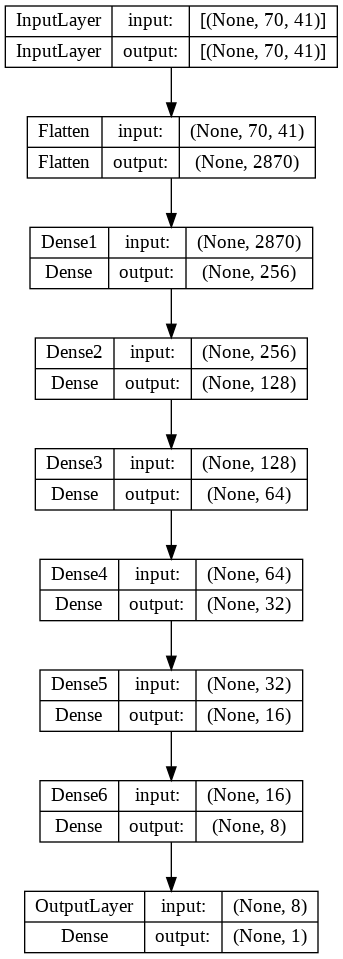

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(func_model, show_shapes=True, show_layer_names=True)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='val_auroc', mode='max', patience=12, verbose=1)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_auroc', verbose=1, mode='max', save_best_only=True)

func_model_history = func_model.fit(train_X_3d, train_y_3d, epochs=20, batch_size=50, validation_data=(valid_X_3d, valid_y_3d), verbose=1, callbacks=[checkpointer])
func_history = func_model_history.history

Epoch 1/20
110/113 [============================>.] - ETA: 0s - loss: 0.5492 - auroc: 0.8827
Epoch 1: val_auroc improved from -inf to 0.66747, saving model to /content/drive/MyDrive/최종프로젝트/model4/01-0.6675.hdf5
113/113 [==============================] - 3s 14ms/step - loss: 0.5442 - auroc: 0.8848 - val_loss: 0.5140 - val_auroc: 0.6675
Epoch 2/20
110/113 [============================>.] - ETA: 0s - loss: 0.2649 - auroc: 0.9470
Epoch 2: val_auroc did not improve from 0.66747
113/113 [==============================] - 1s 10ms/step - loss: 0.2645 - auroc: 0.9469 - val_loss: 0.3851 - val_auroc: 0.6598
Epoch 3/20
110/113 [============================>.] - ETA: 0s - loss: 0.2270 - auroc: 0.9502
Epoch 3: val_auroc improved from 0.66747 to 0.68469, saving model to /content/drive/MyDrive/최종프로젝트/model4/03-0.6847.hdf5
113/113 [==============================] - 1s 11ms/step - loss: 0.2260 - auroc: 0.9503 - val_loss: 0.3775 - val_auroc: 0.6847
Epoch 4/20
111/113 [====================

# **Light GBM**

In [ ]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

lgbm_model=LGBMClassifier(n_estimators=700)
lgbm_model.fit(train_X_over, train_y_over, early_stopping_rounds=100, eval_metric="auc", eval_set=(valid_X, valid_y), verbose=True)
lgbm_pred=lgbm_model.predict(test_X)


[1]	valid_0's binary_logloss: 0.676215	valid_0's auc: 0.654795
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.663157	valid_0's auc: 0.654038
[3]	valid_0's binary_logloss: 0.652128	valid_0's auc: 0.658145
[4]	valid_0's binary_logloss: 0.642454	valid_0's auc: 0.666981
[5]	valid_0's binary_logloss: 0.633427	valid_0's auc: 0.668535
[6]	valid_0's binary_logloss: 0.625944	valid_0's auc: 0.671313
[7]	valid_0's binary_logloss: 0.620676	valid_0's auc: 0.671568
[8]	valid_0's binary_logloss: 0.614111	valid_0's auc: 0.6759
[9]	valid_0's binary_logloss: 0.605807	valid_0's auc: 0.683623
[10]	valid_0's binary_logloss: 0.599538	valid_0's auc: 0.68175
[11]	valid_0's binary_logloss: 0.59406	valid_0's auc: 0.693127
[12]	valid_0's binary_logloss: 0.589579	valid_0's auc: 0.698772
[13]	valid_0's binary_logloss: 0.586328	valid_0's auc: 0.703835
[14]	valid_0's binary_logloss: 0.581241	valid_0's auc: 0.702023
[15]	valid_0's binary_logloss: 0.578138	valid_0's auc:

In [ ]:
# AUC
auc_score = roc_auc_score(test_y, lgbm_pred)
print(auc_score)

0.6005210306934444


In [ ]:
import lightgbm as lgb

train = lgb.Dataset(train_X_over, label=train_y_over)
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'auc'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10
clf = lgb.train(params, train, 100)

pred_y = clf.predict(test_X)

# AUC
auc = roc_auc_score(test_y, pred_y)
print(auc)

0.692148659530125


In [ ]:
import lightgbm as lgb

lgb_clf = lgb.LGBMClassifier(num_leaves=31, objective='binary')
lgb_clf.fit(train_X_over, train_y_over)
y_pred = lgb_clf.predict(test_X)
print(roc_auc_score(test_y, y_pred))

0.692148659530125


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

lgbm = LGBMClassifier(n_estimators=200)

params = {'max_depth': [10, 15, 20],
          'min_child_samples': [20, 40, 60],
          'subsample': [0.8, 1],
          'boosting': ['gbdt', 'rf']}

grid = GridSearchCV(lgbm, param_grid=params)
grid.fit(train_X_over, train_y_over, early_stopping_rounds=100, eval_metric='auc', eval_set=[(valid_X, valid_y)])

print("최적 파라미터: ", grid.best_params_)

lgbm_roc_score = roc_auc_score(test_y, grid.predict_proba(test_X)[:, 1], average='macro')
print("ROC AUC: {0:.4f}".format(lgbm_roc_score))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[42]	valid_0's binary_logloss: 0.508432	valid_0's auc: 0.711063
[43]	valid_0's binary_logloss: 0.518504	valid_0's auc: 0.711445
[44]	valid_0's binary_logloss: 0.515091	valid_0's auc: 0.712606
[45]	valid_0's binary_logloss: 0.513139	valid_0's auc: 0.71354
[46]	valid_0's binary_logloss: 0.508894	valid_0's auc: 0.713522
[47]	valid_0's binary_logloss: 0.514551	valid_0's auc: 0.712628
[48]	valid_0's binary_logloss: 0.51266	valid_0's auc: 0.713296
[49]	valid_0's binary_logloss: 0.522858	valid_0's auc: 0.713531
[50]	valid_0's binary_logloss: 0.522404	valid_0's auc: 0.712782
[51]	valid_0's binary_logloss: 0.520439	valid_0's auc: 0.712658
[52]	valid_0's binary_logloss: 0.519489	valid_0's auc: 0.712113
[53]	valid_0's binary_logloss: 0.518293	valid_0's auc: 0.712037
[54]	valid_0's binary_logloss: 0.517625	valid_0's auc: 0.712383
[55]	valid_0's binary_logloss: 0.515676	valid_0's auc: 0.713638
[56]	valid_0's binary_logloss: 0.535702	valid_0's auc: 0.711779
[57]	v

> 최적 파라미터:  {'boosting': 'gbdt', 'max_depth': 15, 'min_child_samples': 40, 'subsample': 0.8}<br>
ROC AUC: 0.7124

In [ ]:
# 결과 적용
lgbm = LGBMClassifier(n_estimators=1000, num_leaves=50, subsample=0.8, min_child_samples=40, max_depth=15)
lgbm.fit(train_X_over, train_y_over, early_stopping_rounds=100, eval_metric='auc', eval_set=(valid_X, valid_y), verbose=True)
lgbm_pred = lgbm.predict_proba(test_X)[:, 1]
score = roc_auc_score(test_y, lgbm_pred, average='macro')
print("ROC AUC: {0:.4f}".format(score))

[1]	valid_0's binary_logloss: 0.674785	valid_0's auc: 0.642156
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.660305	valid_0's auc: 0.648674
[3]	valid_0's binary_logloss: 0.646994	valid_0's auc: 0.663842
[4]	valid_0's binary_logloss: 0.636197	valid_0's auc: 0.666316
[5]	valid_0's binary_logloss: 0.625947	valid_0's auc: 0.673028
[6]	valid_0's binary_logloss: 0.6176	valid_0's auc: 0.677527
[7]	valid_0's binary_logloss: 0.610675	valid_0's auc: 0.678516
[8]	valid_0's binary_logloss: 0.604576	valid_0's auc: 0.681003
[9]	valid_0's binary_logloss: 0.598478	valid_0's auc: 0.686495
[10]	valid_0's binary_logloss: 0.592343	valid_0's auc: 0.689099
[11]	valid_0's binary_logloss: 0.585816	valid_0's auc: 0.691138
[12]	valid_0's binary_logloss: 0.579802	valid_0's auc: 0.694087
[13]	valid_0's binary_logloss: 0.576888	valid_0's auc: 0.695065
[14]	valid_0's binary_logloss: 0.572565	valid_0's auc: 0.698846
[15]	valid_0's binary_logloss: 0.567044	valid_0's au

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print('LGBMClassifier')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
lgbm_clf.fit(train_X_over, train_y_over)
lgbm_pred = lgbm_clf.predict(test_X)
lgbm_pred_proba = lgbm_clf.predict_proba(test_X)[:,1]
print('roc auc score :', roc_auc_score(test_y, lgbm_pred_proba))

# **AUROC**

In [ ]:
# save model
model.save('/content/drive/MyDrive/최종프로젝트/model4/ann_model.h5')

rnn1_model.save('/content/drive/MyDrive/최종프로젝트/model4/rnn1_model.h5')
lstm1_model.save('/content/drive/MyDrive/최종프로젝트/model4/lstm1_model.h5')
gru1_model.save('/content/drive/MyDrive/최종프로젝트/model4/gru1_model.h5')

rnn2_model.save('/content/drive/MyDrive/최종프로젝트/model4/rnn2_model.h5')
lstm2_model.save('/content/drive/MyDrive/최종프로젝트/model4/lstm2_model.h5')
gru2_model.save('/content/drive/MyDrive/최종프로젝트/model4/gru2_model.h5')

cnn1_model.save('/content/drive/MyDrive/최종프로젝트/model4/cnn1_model.h5')
cnn2_model.save('/content/drive/MyDrive/최종프로젝트/model4/cnn2_model.h5')
cnn3_model.save('/content/drive/MyDrive/최종프로젝트/model4/cnn3_model.h5')
cnn4_model.save('/content/drive/MyDrive/최종프로젝트/model4/cnn4_model.h5')

func_model.save('/content/drive/MyDrive/최종프로젝트/model4/func_model.h5')

# import joblib

# joblib.dump(lgbm,'/content/drive/MyDrive/최종프로젝트/model4/lgbm_model.pkl')

In [ ]:
# load model
from keras.models import load_model
loaded_ann_model = load_model('/content/drive/MyDrive/최종프로젝트/model4/ann-12-0.7865.hdf5')

loaded_rnn1_model = load_model('/content/drive/MyDrive/최종프로젝트/model4/rnn1-07-0.7463.hdf5')
loaded_lstm1_model = load_model('/content/drive/MyDrive/최종프로젝트/model4/lstm1-20-0.7724.hdf5')
loaded_gru1_model = load_model('/content/drive/MyDrive/최종프로젝트/model4/gru1-20-0.7692.hdf5-')

loaded_rnn2_model = load_model('/content/drive/MyDrive/최종프로젝트/model4/rnn2-15-0.7486.hdf5')
loaded_lstm2_model = load_model('/content/drive/MyDrive/최종프로젝트/model4/lstm2-16-0.7536.hdf5')
loaded_gru2_model = load_model('/content/drive/MyDrive/최종프로젝트/model4/gru2-20-0.7691.hdf5')

loaded_cnn1_model = load_model('/content/drive/MyDrive/최종프로젝트/model4/cnn1-18-0.7774.hdf5')
loaded_cnn2_model = load_model('/content/drive/MyDrive/최종프로젝트/model4/cnn2-17-0.8021.hdf5')
loaded_cnn3_model = load_model('/content/drive/MyDrive/최종프로젝트/model4/cnn3-11-0.8026.hdf5')
loaded_cnn4_model = load_model('/content/drive/MyDrive/최종프로젝트/model4/cnn4-17-0.7869.hdf5')

loaded_func_model = load_model('/content/drive/MyDrive/최종프로젝트/model4/func-19-0.7732.hdf5')

# loaded_lgbm_model = joblib.load('/content/drive/MyDrive/최종프로젝트/model3/lgbm_model.pkl')

In [ ]:
# model score
ann_model_score = model.evaluate(test_X_3d, test_y_3d)

rnn1_model_score = rnn1_model.evaluate(test_X_3d, test_y_3d)
lstm1_model_score = lstm1_model.evaluate(test_X_3d, test_y_3d)
gru1_model_score = gru1_model.evaluate(test_X_3d, test_y_3d)

rnn2_model_score = rnn2_model.evaluate(test_X_3d, test_y_3d)
lstm2_model_score = lstm2_model.evaluate(test_X_3d, test_y_3d)
gru2_model_score = gru2_model.evaluate(test_X_3d, test_y_3d)

cnn1_model_score = cnn1_model.evaluate(test_X_3d, test_y_3d)
cnn2_model_score = cnn2_model.evaluate(test_X_3d, test_y_3d)
cnn3_model_score = cnn3_model.evaluate(test_X_3d, test_y_3d)
cnn4_model_score = cnn4_model.evaluate(test_X_3d, test_y_3d)

func_model_score = func_model.evaluate(test_X_3d, test_y_3d)

# lgbm_model_score = lgbm.score(test_X, test_y)

13/13 [==============================] - 0s 5ms/step - loss: 0.3378 - auroc: 0.7516


In [ ]:
# loaded_model score
loaded_ann_model_score = loaded_ann_model.evaluate(test_X_3d, test_y_3d)

loaded_rnn1_model_score = loaded_rnn1_model.evaluate(test_X_3d, test_y_3d)
loaded_lstm1_model_score = loaded_lstm1_model.evaluate(test_X_3d, test_y_3d)
loaded_gru1_model_score = loaded_gru1_model.evaluate(test_X_3d, test_y_3d)

loaded_rnn2_model_score = loaded_rnn2_model.evaluate(test_X_3d, test_y_3d)
loaded_lstm2_model_score = loaded_lstm2_model.evaluate(test_X_3d, test_y_3d)
loaded_gru2_model_score = loaded_gru2_model.evaluate(test_X_3d, test_y_3d)

loaded_cnn1_model_score = loaded_cnn1_model.evaluate(test_X_3d, test_y_3d)
loaded_cnn2_model_score = loaded_cnn2_model.evaluate(test_X_3d, test_y_3d)
loaded_cnn3_model_score = loaded_cnn3_model.evaluate(test_X_3d, test_y_3d)
loaded_cnn4_model_score = loaded_cnn4_model.evaluate(test_X_3d, test_y_3d)

loaded_func_model_score = loaded_func_model.evaluate(test_X_3d, test_y_3d)

# loaded_lgbm_model_score = loaded_lgbm_model.score(test_X, test_y)

13/13 [==============================] - 1s 10ms/step - loss: 0.3596 - auroc: 0.7802


In [ ]:
# predict
ann_pred = model.predict(test_X_3d)

rnn1_pred = rnn1_model.predict(test_X_3d)
lstm1_pred = lstm1_model.predict(test_X_3d)
gru1_pred = gru1_model.predict(test_X_3d)

rnn2_pred = rnn2_model.predict(test_X_3d)
lstm2_pred = lstm2_model.predict(test_X_3d)
gru2_pred = gru2_model.predict(test_X_3d)

cnn1_pred = cnn1_model.predict(test_X_3d)
cnn2_pred = cnn2_model.predict(test_X_3d)
cnn3_pred = cnn3_model.predict(test_X_3d)
cnn4_pred = cnn4_model.predict(test_X_3d)

func_pred = func_model.predict(test_X_3d)

# lgbm_pred = lgbm.predict_proba(test_X)[:, 1]

13/13 [==============================] - 0s 3ms/step


In [ ]:
# loaded_model predict
loaded_ann_pred = loaded_ann_model.predict(test_X_3d)

loaded_rnn1_pred = loaded_rnn1_model.predict(test_X_3d)
loaded_lstm1_pred = loaded_lstm1_model.predict(test_X_3d)
loaded_gru1_pred = loaded_gru1_model.predict(test_X_3d)

loaded_rnn2_pred = loaded_rnn2_model.predict(test_X_3d)
loaded_lstm2_pred = loaded_lstm2_model.predict(test_X_3d)
loaded_gru2_pred = loaded_gru2_model.predict(test_X_3d)

loaded_cnn1_pred = loaded_cnn1_model.predict(test_X_3d)
loaded_cnn2_pred = loaded_cnn2_model.predict(test_X_3d)
loaded_cnn3_pred = loaded_cnn3_model.predict(test_X_3d)
loaded_cnn4_pred = loaded_cnn4_model.predict(test_X_3d)

loaded_func_pred = loaded_func_model.predict(test_X_3d)

# loaded_lgbm_pred = loaded_lgbm_model.predict_proba(test_X)[:, 1]

13/13 [==============================] - 0s 3ms/step


In [ ]:
# score 
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import precision_recall_curve, roc_curve, classification_report, accuracy_score, roc_auc_score, average_precision_score

In [ ]:
# ANN
ann_fpr, ann_tpr, ann_thresholds = roc_curve(test_y_3d, ann_pred)
ann_roc_auc = roc_auc_score(test_y_3d, ann_pred)

# RNN
rnn1_fpr, rnn1_tpr, rnn1_thresholds = roc_curve(test_y_3d, rnn1_pred)
rnn1_roc_auc = roc_auc_score(test_y_3d, rnn1_pred)

rnn2_fpr, rnn2_tpr, rnn2_thresholds = roc_curve(test_y_3d, rnn2_pred)
rnn2_roc_auc = roc_auc_score(test_y_3d, rnn2_pred)

# LSTM
lstm1_fpr, lstm1_tpr, lstm1_thresholds = roc_curve(test_y_3d, lstm1_pred)
lstm1_roc_auc = roc_auc_score(test_y_3d, lstm1_pred)

lstm2_fpr, lstm2_tpr, lstm2_thresholds = roc_curve(test_y_3d, lstm2_pred)
lstm2_roc_auc = roc_auc_score(test_y_3d, lstm2_pred)

# GRU
gru1_fpr, gru1_tpr, gru1_thresholds = roc_curve(test_y_3d, gru1_pred)
gru1_roc_auc = roc_auc_score(test_y_3d, gru1_pred)

gru2_fpr, gru2_tpr, gru2_thresholds = roc_curve(test_y_3d, gru2_pred)
gru2_roc_auc = roc_auc_score(test_y_3d, gru2_pred)

# CNN
cnn1_fpr, cnn1_tpr, cnn1_thresholds = roc_curve(test_y_3d, cnn1_pred)
cnn1_roc_auc = roc_auc_score(test_y_3d, cnn1_pred)

cnn2_fpr, cnn2_tpr, cnn2_thresholds = roc_curve(test_y_3d, cnn2_pred)
cnn2_roc_auc = roc_auc_score(test_y_3d, cnn2_pred)

cnn3_fpr, cnn3_tpr, cnn3_thresholds = roc_curve(test_y_3d, cnn3_pred)
cnn3_roc_auc = roc_auc_score(test_y_3d, cnn3_pred)

cnn4_fpr, cnn4_tpr, cnn4_thresholds = roc_curve(test_y_3d, cnn4_pred)
cnn4_roc_auc = roc_auc_score(test_y_3d, cnn4_pred)

# Func api
func_fpr, func_tpr, func_thresholds = roc_curve(test_y_3d, func_pred)
func_roc_auc = roc_auc_score(test_y_3d, func_pred)

# LGBM
lgbm_fpr, lgbm_tpr, lgbm_thresholds = roc_curve(test_y, lgbm_pred)
lgbm_roc_auc = roc_auc_score(test_y, lgbm_pred)

In [ ]:
# loaded
# ANN
loaded_ann_fpr, loaded_ann_tpr, loaded_ann_thresholds = roc_curve(test_y_3d, loaded_ann_pred)
loaded_ann_roc_auc = roc_auc_score(test_y_3d, loaded_ann_pred)

# RNN
loaded_rnn1_fpr, loaded_rnn1_tpr, loaded_rnn1_thresholds = roc_curve(test_y_3d, loaded_rnn1_pred)
loaded_rnn1_roc_auc = roc_auc_score(test_y_3d, loaded_rnn1_pred)

loaded_rnn2_fpr, loaded_rnn2_tpr, loaded_rnn2_thresholds = roc_curve(test_y_3d, loaded_rnn2_pred)
loaded_rnn2_roc_auc = roc_auc_score(test_y_3d, loaded_rnn2_pred)

# LSTM
loaded_lstm1_fpr, loaded_lstm1_tpr, loaded_lstm1_thresholds = roc_curve(test_y_3d, loaded_lstm1_pred)
loaded_lstm1_roc_auc = roc_auc_score(test_y_3d, loaded_lstm1_pred)

loaded_lstm2_fpr, loaded_lstm2_tpr, loaded_lstm2_thresholds = roc_curve(test_y_3d, loaded_lstm2_pred)
loaded_lstm2_roc_auc = roc_auc_score(test_y_3d, loaded_lstm2_pred)

# GRU
loaded_gru1_fpr, loaded_gru1_tpr, loaded_gru1_thresholds = roc_curve(test_y_3d, loaded_gru1_pred)
loaded_gru1_roc_auc = roc_auc_score(test_y_3d, loaded_gru1_pred)

loaded_gru2_fpr, loaded_gru2_tpr, loaded_gru2_thresholds = roc_curve(test_y_3d, loaded_gru2_pred)
loaded_gru2_roc_auc = roc_auc_score(test_y_3d, loaded_gru2_pred)

# CNN
loaded_cnn1_fpr, loaded_cnn1_tpr, loaded_cnn1_thresholds = roc_curve(test_y_3d, loaded_cnn1_pred)
loaded_cnn1_roc_auc = roc_auc_score(test_y_3d, loaded_cnn1_pred)

loaded_cnn2_fpr, loaded_cnn2_tpr, loaded_cnn2_thresholds = roc_curve(test_y_3d, loaded_cnn2_pred)
loaded_cnn2_roc_auc = roc_auc_score(test_y_3d, loaded_cnn2_pred)

loaded_cnn3_fpr, loaded_cnn3_tpr, loaded_cnn3_thresholds = roc_curve(test_y_3d, loaded_cnn3_pred)
loaded_cnn3_roc_auc = roc_auc_score(test_y_3d, loaded_cnn3_pred)

loaded_cnn4_fpr, loaded_cnn4_tpr, loaded_cnn4_thresholds = roc_curve(test_y_3d, loaded_cnn4_pred)
loaded_cnn4_roc_auc = roc_auc_score(test_y_3d, loaded_cnn4_pred)

# Func api
# loaded_func_fpr, loaded_func_tpr, loaded_func_thresholds = roc_curve(test_y_3d, loaded_func_pred)
# loaded_func_roc_auc = roc_auc_score(test_y_3d, loaded_func_pred)

# LGBM
# loaded_lgbm_fpr, loaded_lgbm_tpr, loaded_lgbm_thresholds = roc_curve(test_y, loaded_lgbm_pred)
# loaded_lgbm_roc_auc = roc_auc_score(test_y_3d, loaded_lgbm_pred)

In [ ]:
print('ANN_ROC AUC Score: ', roc_auc_score(test_y_3d, ann_pred))
print()
print('RNN1_ROC AUC Score: ', roc_auc_score(test_y_3d, rnn1_pred))
print('LSTM1_ROC AUC Score: ', roc_auc_score(test_y_3d, lstm1_pred))
print('GRU1_ROC AUC Score: ', roc_auc_score(test_y_3d, gru1_pred))
print()
print('RNN2_ROC AUC Score: ', roc_auc_score(test_y_3d, rnn2_pred))
print('LSTM2_ROC AUC Score: ', roc_auc_score(test_y_3d, lstm2_pred))
print('GRU2_ROC AUC Score: ', roc_auc_score(test_y_3d, gru2_pred))
print()
print('CNN1_ROC AUC Score: ', roc_auc_score(test_y_3d, cnn1_pred))
print('CNN2_ROC AUC Score: ', roc_auc_score(test_y_3d, cnn2_pred))
print('CNN3_ROC AUC Score: ', roc_auc_score(test_y_3d, cnn3_pred))
print('CNN4_ROC AUC Score: ', roc_auc_score(test_y_3d, cnn4_pred))
print()
print('Func_ROC AUC Score: ', roc_auc_score(test_y_3d, func_pred))
print()
# print('LGBM_ROC AUC Score: ', roc_auc_score(test_y, lgbm_pred))

ANN_ROC AUC Score:  0.7664677276746242

RNN1_ROC AUC Score:  0.7218169761273209
LSTM1_ROC AUC Score:  0.7280614500442087
GRU1_ROC AUC Score:  0.7556366047745358

RNN2_ROC AUC Score:  0.6804818744473916
LSTM2_ROC AUC Score:  0.717948717948718
GRU2_ROC AUC Score:  0.7403846153846153

CNN1_ROC AUC Score:  0.7172855879752431
CNN2_ROC AUC Score:  0.7582338638373121
CNN3_ROC AUC Score:  0.7760278514588859
CNN4_ROC AUC Score:  0.7824381078691424

Func_ROC AUC Score:  0.7203801945181255



In [ ]:
print('ANN_ROC AUC Score: ', roc_auc_score(test_y_3d, loaded_ann_pred))
print()
print('RNN1_ROC AUC Score: ', roc_auc_score(test_y_3d, loaded_rnn1_pred))
print('LSTM1_ROC AUC Score: ', roc_auc_score(test_y_3d, loaded_lstm1_pred))
print('GRU1_ROC AUC Score: ', roc_auc_score(test_y_3d, loaded_gru1_pred))
print()
print('RNN2_ROC AUC Score: ', roc_auc_score(test_y_3d, loaded_rnn2_pred))
print('LSTM2_ROC AUC Score: ', roc_auc_score(test_y_3d, loaded_lstm2_pred))
print('GRU2_ROC AUC Score: ', roc_auc_score(test_y_3d, loaded_gru2_pred))
print()
print('CNN1_ROC AUC Score: ', roc_auc_score(test_y_3d, loaded_cnn1_pred))
print('CNN2_ROC AUC Score: ', roc_auc_score(test_y_3d, loaded_cnn2_pred))
print('CNN3_ROC AUC Score: ', roc_auc_score(test_y_3d, loaded_cnn3_pred))
print('CNN4_ROC AUC Score: ', roc_auc_score(test_y_3d, loaded_cnn4_pred))
print()
print('Func_ROC AUC Score: ', roc_auc_score(test_y_3d, loaded_func_pred))
print()
# print('LGBM_ROC AUC Score: ', roc_auc_score(test_y, loaded_lgbm_pred))

ANN_ROC AUC Score:  0.7485079575596817

RNN1_ROC AUC Score:  0.7234748010610079
LSTM1_ROC AUC Score:  0.7280614500442087
GRU1_ROC AUC Score:  0.7556366047745358

RNN2_ROC AUC Score:  0.711814765694076
LSTM2_ROC AUC Score:  0.7046308576480991
GRU2_ROC AUC Score:  0.7403846153846153

CNN1_ROC AUC Score:  0.7322612732095491
CNN2_ROC AUC Score:  0.7674071618037135
CNN3_ROC AUC Score:  0.7729332449160036
CNN4_ROC AUC Score:  0.7949270557029178

Func_ROC AUC Score:  0.7311560565870912



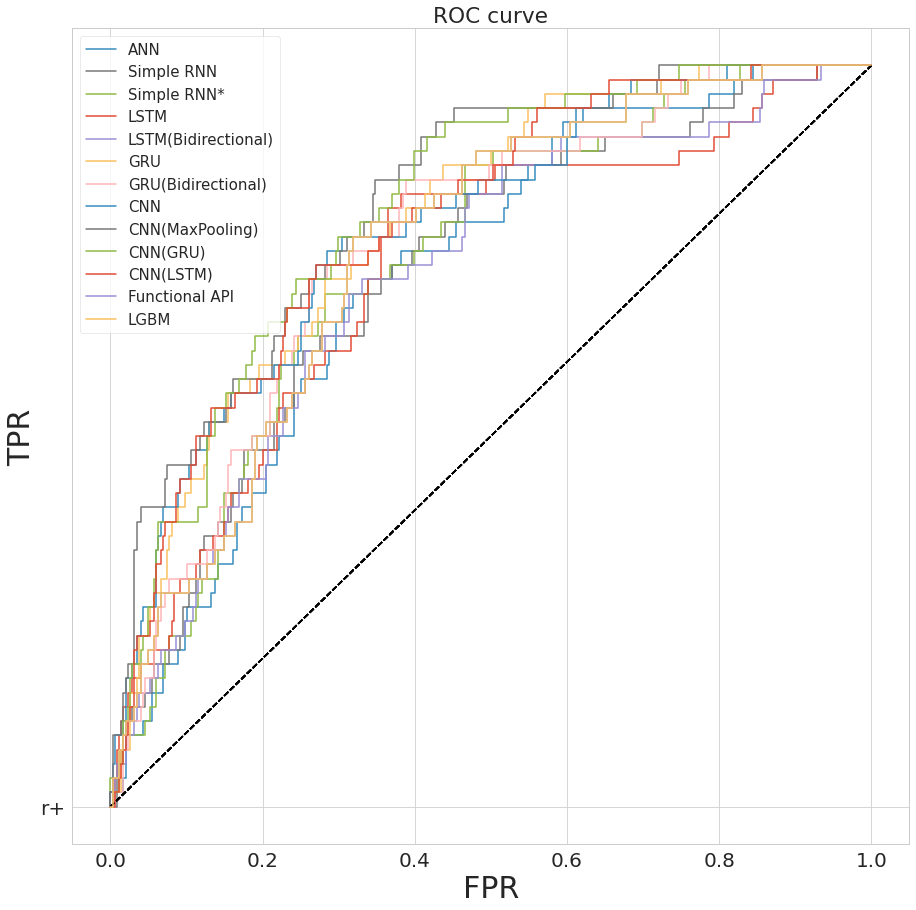

In [ ]:
# ROC Curve
from sklearn.metrics import roc_curve

plt.figure(figsize=(15,15))

plt.rc('font', size=15)        # 기본 폰트 크기
plt.rc('axes', labelsize=30)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('figure', titlesize=20) # figure title 폰트 크기

loaded_ann_fpr, loaded_ann_tpr, loaded_ann_thresholds = roc_curve(test_y_3d, loaded_ann_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(loaded_ann_fpr, loaded_ann_tpr, label='ANN')

loaded_rnn1_fpr, loaded_rnn1_tpr, loaded_rnn1_thresholds = roc_curve(test_y_3d, loaded_rnn1_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(loaded_rnn1_fpr, loaded_rnn1_tpr, label='Simple RNN')

loaded_rnn2_fpr, loaded_rnn2_tpr, loaded_rnn2_thresholds = roc_curve(test_y_3d, loaded_rnn2_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(loaded_rnn2_fpr, loaded_rnn2_tpr, label='Simple RNN*')

loaded_lstm1_fpr, loaded_lstm1_tpr, loaded_lstm1_thresholds = roc_curve(test_y_3d, loaded_lstm1_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(loaded_lstm1_fpr, loaded_lstm1_tpr, label='LSTM')

loaded_lstm2_fpr, loaded_lstm2_tpr, loaded_lstm2_thresholds = roc_curve(test_y_3d, loaded_lstm2_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(loaded_lstm2_fpr, loaded_lstm2_tpr, label='LSTM(Bidirectional)')

loaded_gru1_fpr, loaded_gru1_tpr, loaded_gru1_thresholds = roc_curve(test_y_3d, loaded_gru1_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(loaded_gru1_fpr, loaded_gru1_tpr, label='GRU')

loaded_gru2_fpr, loaded_gru2_tpr, loaded_gru2_thresholds = roc_curve(test_y_3d, loaded_gru2_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(loaded_gru2_fpr, loaded_gru2_tpr, label='GRU(Bidirectional)')

loaded_cnn1_fpr, loaded_cnn1_tpr, loaded_cnn1_thresholds = roc_curve(test_y_3d, loaded_cnn1_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(loaded_cnn1_fpr, loaded_cnn1_tpr, label='CNN')

loaded_cnn2_fpr, loaded_cnn2_tpr, loaded_cnn2_thresholds = roc_curve(test_y_3d, loaded_cnn2_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(loaded_cnn2_fpr, loaded_cnn2_tpr, label='CNN(MaxPooling)')

cnn3_fpr, cnn3_tpr, cnn3_thresholds = roc_curve(test_y_3d, cnn3_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(cnn3_fpr, cnn3_tpr, label='CNN(GRU)')

cnn4_fpr, cnn4_tpr, cnn4_thresholds = roc_curve(test_y_3d, cnn4_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(cnn4_fpr, cnn4_tpr, label='CNN(LSTM)')

func_fpr, func_tpr, func_thresholds = roc_curve(test_y_3d, func_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(func_fpr, func_tpr, label='Functional API')

lgbm_fpr, lgbm_tpr, lgbm_thresholds = roc_curve(test_y, lgbm_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(func_fpr, func_tpr, label='LGBM')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='upper left')
plt.title('ROC curve')
plt.show()


In [ ]:
# F_positive_rate, T_positive_rate 구하기
ocsvmF_positive_rate, ocsvmT_positive_rate, ocsvm_thresholds =roc_curve(pred_ocsvm, y_test)
isfF_positive_rate, isfT_positive_rate, isv_thresholds =roc_curve(pred_isf, y_test)
xgF_positive_rate, xgT_positive_rate, xg_thresholds =roc_curve(pred_xg, y_test)
 
#roc_auc
ocsvm_roc_auc = auc(ocsvmF_positive_rate, ocsvmT_positive_rate)
isf_roc_auc = auc(isfF_positive_rate, isfT_positive_rate)
xg_roc_auc = auc(xgF_positive_rate, xgT_positive_rate)
 
plt.step(ocsvmF_positive_rate, ocsvmT_positive_rate, color='blue', lw=2)
plt.step(isfF_positive_rate, isfT_positive_rate, color='red', lw=2)
plt.step(xgF_positive_rate, xgT_positive_rate, color='green', lw=2)
 
plt.legend(['ocsvm','isf','xg'])
plt.show()

# **DF 만들기**

In [ ]:
df = pd.DataFrame(ann_pred, columns=['ann_pred'])
df['rnn1_pred'] = loaded_rnn1_pred
df['rnn2_pred'] = loaded_rnn2_pred
df['lstm1_pred'] = loaded_lstm1_pred
df['lstm2_pred'] = lstm2_pred
df['gru1_pred'] = loaded_gru1_pred
df['gru2_pred'] = loaded_gru2_pred
df['cnn1_pred'] = loaded_cnn1_pred
df['cnn2_pred'] = loaded_cnn2_pred
df['cnn3_pred'] = cnn3_pred
df['cnn4_pred'] = loaded_cnn4_pred
df['func_pred'] = loaded_func_pred
df['label'] = l
df

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/최종프로젝트/missing_values_test_data.csv')
test_df.drop(['Unnamed: 0'], axis=1, inplace=True)
test_df

,pid,age,Gender,ICUType,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,FiO2,GCS,Glucose,HCO3,HCT,HR,K,Lactate,Mg,Na,PaCO2,PaO2,Platelets,RR,SPO2,BT,TroponinI,TroponinT,Urine,WBC,pH,MechVent,SBP,DBP,MBP,LOS,label
0,135089,90.0,1.0,3.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,6,0
1,135089,90.0,1.0,3.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.9,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,6,0
2,135089,90.0,1.0,3.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,130.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,28.0,97.0,38.7,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,6,0
3,135089,90.0,1.0,3.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,130.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,22.0,97.0,38.7,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,6,0
4,135089,90.0,1.0,3.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,123.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,23.0,97.0,38.7,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29549,135219,78.0,0.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,59.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,22.0,98.0,37.6,2.6,0.18,35.0,11.0,7.38,1.0,134.0,51.0,79.0,9,0
29550,135219,78.0,0.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,60.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,22.0,98.0,37.6,2.6,0.18,75.0,11.0,7.38,1.0,132.0,50.0,78.0,9,0
29551,135219,78.0,0.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,66.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,18.0,98.0,37.7,2.6,0.18,45.0,11.0,7.38,1.0,139.0,54.0,84.0,9,0
29552,135219,78.0,0.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,66.0,4.0,2.0,2.0,139.0,40.0,90.0,170.5,18.0,98.0,37.7,2.6,0.18,75.0,11.0,7.37,1.0,139.0,54.0,84.0,9,0


In [ ]:
# 입력 첫번째 값
first_record = test_df.drop_duplicates(subset='pid',keep='first')
first_record = first_record.reset_index(drop=True)

In [ ]:
# 입력 마지막 값
last_record = test_df.drop_duplicates(subset='pid',keep='last')
last_record = last_record.reset_index(drop=True)

In [ ]:
# pid 별 묶어서 평균
mean_record = test_df.groupby('pid').mean().reset_index()

In [ ]:
first_record.to_csv('/content/drive/MyDrive/최종프로젝트/pid_first_rec.csv')
last_record.to_csv('/content/drive/MyDrive/최종프로젝트/pid_last_rec.csv')
mean_record.to_csv('/content/drive/MyDrive/최종프로젝트/pid_mean_rec.csv')

In [ ]:
eda_df = pd.read_csv('/content/drive/MyDrive/최종프로젝트/EDA_data.csv')
eda_df.drop(['Unnamed: 0'], axis=1, inplace=True)
eda_df

,pid,age,Gender,ICUType,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,FiO2,GCS,Glucose,HCO3,HCT,HR,K,Lactate,Mg,Na,PaCO2,PaO2,Platelets,RR,SPO2,BT,TroponinI,TroponinT,Urine,WBC,pH,MechVent,SBP,DBP,MBP,LOS,ann_pred,rnn1_pred,rnn2_pred,lstm1_pred,lstm2_pred,gru1_pred,gru2_pred,cnn1_pred,cnn2_pred,cnn3_pred,cnn4_pred,func_pred,label
0,135089,90.0,1.0,3.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,6,0.099120,0.112077,0.204672,0.171169,0.235913,0.150944,0.174046,0.322181,0.056866,0.119137,0.364216,0.200010,0
1,142245,86.0,1.0,2.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,7,0.005208,0.034686,0.008110,0.077271,0.062219,0.937243,0.104222,0.111010,0.049072,0.031105,0.041848,0.075994,0
2,137989,63.0,0.0,3.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,47,0.156299,0.057729,0.166422,0.097842,0.120842,0.105919,0.090831,0.116229,0.035898,0.108247,0.148067,0.122211,0
3,142184,74.0,0.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,37,0.073247,0.183097,0.198213,0.098188,0.244136,0.179208,0.177917,0.152520,0.028672,0.129102,0.256332,0.163652,0
4,134318,48.0,1.0,3.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,14,0.011111,0.041765,0.081276,0.045393,0.044053,0.058858,0.070369,0.078450,0.006324,0.022714,0.095606,0.053279,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,139907,39.0,0.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,84,0.079771,0.097366,0.172374,0.046639,0.159426,0.141626,0.141123,0.118544,0.042659,0.117666,0.206911,0.077982,0
396,136230,75.0,1.0,1.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,9,0.051257,0.033623,0.115285,0.037716,0.214024,0.067754,0.049910,0.149400,0.007528,0.025884,0.050034,0.057867,0
397,139358,71.0,1.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,28,0.112227,0.086915,0.188699,0.057281,0.220872,0.086642,0.182242,0.190067,0.022601,0.095566,0.171188,0.100311,1
398,137755,81.0,0.0,2.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,14,0.019229,0.037743,0.051160,0.037147,0.076601,0.071705,0.022302,0.060466,0.008726,0.054384,0.058619,0.030691,0


In [ ]:
pred_df = eda_df[['ann_pred', 'rnn1_pred', 'rnn2_pred', 'lstm1_pred', 'lstm2_pred', 'gru1_pred', 'gru2_pred', 'cnn1_pred', 'cnn2_pred', 'cnn3_pred', 'cnn4_pred', 'func_pred', 'label']]
pred_df

,ann_pred,rnn1_pred,rnn2_pred,lstm1_pred,lstm2_pred,gru1_pred,gru2_pred,cnn1_pred,cnn2_pred,cnn3_pred,cnn4_pred,func_pred,label
0,0.099120,0.112077,0.204672,0.171169,0.235913,0.150944,0.174046,0.322181,0.056866,0.119137,0.364216,0.200010,0
1,0.005208,0.034686,0.008110,0.077271,0.062219,0.937243,0.104222,0.111010,0.049072,0.031105,0.041848,0.075994,0
2,0.156299,0.057729,0.166422,0.097842,0.120842,0.105919,0.090831,0.116229,0.035898,0.108247,0.148067,0.122211,0
3,0.073247,0.183097,0.198213,0.098188,0.244136,0.179208,0.177917,0.152520,0.028672,0.129102,0.256332,0.163652,0
4,0.011111,0.041765,0.081276,0.045393,0.044053,0.058858,0.070369,0.078450,0.006324,0.022714,0.095606,0.053279,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.079771,0.097366,0.172374,0.046639,0.159426,0.141626,0.141123,0.118544,0.042659,0.117666,0.206911,0.077982,0
396,0.051257,0.033623,0.115285,0.037716,0.214024,0.067754,0.049910,0.149400,0.007528,0.025884,0.050034,0.057867,0
397,0.112227,0.086915,0.188699,0.057281,0.220872,0.086642,0.182242,0.190067,0.022601,0.095566,0.171188,0.100311,1
398,0.019229,0.037743,0.051160,0.037147,0.076601,0.071705,0.022302,0.060466,0.008726,0.054384,0.058619,0.030691,0


In [ ]:
pred_df.to_csv('/content/drive/MyDrive/최종프로젝트/pred_data.csv')

In [ ]:
first_record = pd.read_csv('/content/drive/MyDrive/최종프로젝트/pid_first_rec.csv')
first_record.drop(['Unnamed: 0'], axis=1, inplace=True)

last_record = pd.read_csv('/content/drive/MyDrive/최종프로젝트/pid_last_rec.csv')
last_record.drop(['Unnamed: 0'], axis=1, inplace=True)

mean_record = pd.read_csv('/content/drive/MyDrive/최종프로젝트/pid_mean_rec.csv')
mean_record.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
pred_df = pd.read_csv('/content/drive/MyDrive/최종프로젝트/pred_data.csv')
pred_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
first_record.drop(['label'], axis=1, inplace=True)
last_record.drop(['label'], axis=1, inplace=True)
mean_record.drop(['label'], axis=1, inplace=True)

In [ ]:
pd.concat([first_record, pred_df], axis=1)

,pid,age,Gender,ICUType,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,FiO2,GCS,Glucose,HCO3,HCT,HR,K,Lactate,Mg,Na,PaCO2,PaO2,Platelets,RR,SPO2,BT,TroponinI,TroponinT,Urine,WBC,pH,MechVent,SBP,DBP,MBP,LOS,ann_pred,rnn1_pred,rnn2_pred,lstm1_pred,lstm2_pred,gru1_pred,gru2_pred,cnn1_pred,cnn2_pred,cnn3_pred,cnn4_pred,func_pred,label
0,135089,90.0,1.0,3.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,6,0.099120,0.112077,0.204672,0.171169,0.235913,0.150944,0.174046,0.322181,0.056866,0.119137,0.364216,0.200010,0
1,142245,86.0,1.0,2.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,7,0.005208,0.034686,0.008110,0.077271,0.062219,0.937243,0.104222,0.111010,0.049072,0.031105,0.041848,0.075994,0
2,137989,63.0,0.0,3.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,47,0.156299,0.057729,0.166422,0.097842,0.120842,0.105919,0.090831,0.116229,0.035898,0.108247,0.148067,0.122211,0
3,142184,74.0,0.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,37,0.073247,0.183097,0.198213,0.098188,0.244136,0.179208,0.177917,0.152520,0.028672,0.129102,0.256332,0.163652,0
4,134318,48.0,1.0,3.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,14,0.011111,0.041765,0.081276,0.045393,0.044053,0.058858,0.070369,0.078450,0.006324,0.022714,0.095606,0.053279,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,139907,39.0,0.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,84,0.079771,0.097366,0.172374,0.046639,0.159426,0.141626,0.141123,0.118544,0.042659,0.117666,0.206911,0.077982,0
396,136230,75.0,1.0,1.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,9,0.051257,0.033623,0.115285,0.037716,0.214024,0.067754,0.049910,0.149400,0.007528,0.025884,0.050034,0.057867,0
397,139358,71.0,1.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,28,0.112227,0.086915,0.188699,0.057281,0.220872,0.086642,0.182242,0.190067,0.022601,0.095566,0.171188,0.100311,1
398,137755,81.0,0.0,2.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,14,0.019229,0.037743,0.051160,0.037147,0.076601,0.071705,0.022302,0.060466,0.008726,0.054384,0.058619,0.030691,0


In [ ]:
first_df = pd.concat([first_record, pred_df], axis=1)
last_df = pd.concat([last_record, pred_df], axis=1)
mean_df = pd.concat([mean_record, pred_df], axis=1)

In [ ]:
first_df.to_csv('/content/drive/MyDrive/최종프로젝트/EDA_data_first.csv')
last_df.to_csv('/content/drive/MyDrive/최종프로젝트/EDA_data_last.csv')
mean_df.to_csv('/content/drive/MyDrive/최종프로젝트/EDA_data_mean.csv')

In [ ]:
# ROC Curve
from sklearn.metrics import roc_curve

plt.figure(figsize=(15,15))

plt.rc('font', size=15)        # 기본 폰트 크기
plt.rc('axes', labelsize=30)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('figure', titlesize=20) # figure title 폰트 크기

for i in new_df.columns:
    fpr, tpr, thresholds = roc_curve(test_y, new_df[new_df[i]])
    plt.plot([0,1], [0,1], "k--", "r+")
    plt.plot(fpr, tpr, label=i)

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='upper left')
plt.title('ROC curve')
plt.show()

# **데이터**

In [ ]:
import numpy as np
import pandas as pd
import math, random
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_style('whitegrid')

# display all columns
pd.set_option('display.max_columns', None)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/최종프로젝트/EDA_data_last.csv')
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data

,pid,age,Gender,ICUType,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,FiO2,GCS,Glucose,HCO3,HCT,HR,K,Lactate,Mg,Na,PaCO2,PaO2,Platelets,RR,SPO2,BT,TroponinI,TroponinT,Urine,WBC,pH,MechVent,SBP,DBP,MBP,LOS,ann_pred,rnn1_pred,rnn2_pred,lstm1_pred,lstm2_pred,gru1_pred,gru2_pred,cnn1_pred,cnn2_pred,cnn3_pred,cnn4_pred,func_pred,label
0,135089,90.0,1.0,3.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,106.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,24.0,97.0,35.6,2.6,0.18,70.0,11.0,7.38,1.0,119.0,62.0,84.0,6,0.099120,0.112077,0.204672,0.171169,0.235913,0.150944,0.174046,0.322181,0.056866,0.119137,0.364216,0.200010,0
1,142245,86.0,1.0,2.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,32.9,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,96.0,37.1,2.6,0.64,75.0,11.0,7.38,1.0,116.0,58.0,77.0,7,0.005208,0.034686,0.008110,0.077271,0.062219,0.937243,0.104222,0.111010,0.049072,0.031105,0.041848,0.075994,0
2,137989,63.0,0.0,3.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,100.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,36.6,2.6,0.18,240.0,11.0,7.38,1.0,116.0,58.0,77.0,47,0.156299,0.057729,0.166422,0.097842,0.120842,0.105919,0.090831,0.116229,0.035898,0.108247,0.148067,0.122211,0
3,142184,74.0,0.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,15.0,127.0,23.0,30.4,104.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,99.0,37.0,2.6,0.18,160.0,11.0,7.38,1.0,187.0,70.0,117.0,37,0.073247,0.183097,0.198213,0.098188,0.244136,0.179208,0.177917,0.152520,0.028672,0.129102,0.256332,0.163652,0
4,134318,48.0,1.0,3.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,15.0,127.0,23.0,30.4,95.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,11.0,97.0,36.9,2.6,0.18,75.0,11.0,7.38,1.0,116.0,66.0,81.0,14,0.011111,0.041765,0.081276,0.045393,0.044053,0.058858,0.070369,0.078450,0.006324,0.022714,0.095606,0.053279,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,139907,39.0,0.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,7.0,127.0,23.0,30.4,128.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,38.1,2.6,0.18,120.0,11.0,7.38,1.0,92.0,52.0,64.0,84,0.079771,0.097366,0.172374,0.046639,0.159426,0.141626,0.141123,0.118544,0.042659,0.117666,0.206911,0.077982,0
396,136230,75.0,1.0,1.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,85.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,15.0,100.0,37.2,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,9,0.051257,0.033623,0.115285,0.037716,0.214024,0.067754,0.049910,0.149400,0.007528,0.025884,0.050034,0.057867,0
397,139358,71.0,1.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,56.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,98.0,35.8,2.6,0.18,120.0,11.0,7.38,1.0,147.0,88.0,112.0,28,0.112227,0.086915,0.188699,0.057281,0.220872,0.086642,0.182242,0.190067,0.022601,0.095566,0.171188,0.100311,1
398,137755,81.0,0.0,2.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,61.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,98.0,37.3,2.6,0.18,45.0,11.0,7.38,1.0,129.0,55.0,81.0,14,0.019229,0.037743,0.051160,0.037147,0.076601,0.071705,0.022302,0.060466,0.008726,0.054384,0.058619,0.030691,0


In [ ]:
essential_df = data[['pid', 'age', 'Gender', 'ICUType', 'HR', 'RR', 'SPO2', 'BT', 'MechVent', 'SBP', 'DBP', 'MBP', 'LOS', 'label']]
essential_df

,pid,age,Gender,ICUType,HR,RR,SPO2,BT,MechVent,SBP,DBP,MBP,LOS,label
0,135089,90.0,1.0,3.0,106.0,24.0,97.0,35.6,1.0,119.0,62.0,84.0,6,0
1,142245,86.0,1.0,2.0,86.0,19.0,96.0,37.1,1.0,116.0,58.0,77.0,7,0
2,137989,63.0,0.0,3.0,100.0,19.0,97.0,36.6,1.0,116.0,58.0,77.0,47,0
3,142184,74.0,0.0,4.0,104.0,19.0,99.0,37.0,1.0,187.0,70.0,117.0,37,0
4,134318,48.0,1.0,3.0,95.0,11.0,97.0,36.9,1.0,116.0,66.0,81.0,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,139907,39.0,0.0,4.0,128.0,19.0,97.0,38.1,1.0,92.0,52.0,64.0,84,0
396,136230,75.0,1.0,1.0,85.0,15.0,100.0,37.2,1.0,116.0,58.0,77.0,9,0
397,139358,71.0,1.0,4.0,56.0,19.0,98.0,35.8,1.0,147.0,88.0,112.0,28,1
398,137755,81.0,0.0,2.0,61.0,19.0,98.0,37.3,1.0,129.0,55.0,81.0,14,0


In [ ]:
essential_df.corr()

,pid,age,Gender,ICUType,HR,RR,SPO2,BT,MechVent,SBP,DBP,MBP,LOS,label
pid,1.000000,-0.104622,-0.030632,0.007589,0.034345,0.095854,-0.010715,0.069101,NaN,0.027664,-0.019922,-0.053434,0.042125,-0.081406
age,-0.104622,1.000000,-0.025497,-0.177901,-0.140344,0.133745,0.015855,-0.144444,NaN,0.089050,-0.100330,-0.005235,-0.036164,0.173360
Gender,-0.030632,-0.025497,1.000000,-0.105113,-0.045981,-0.058561,-0.016173,0.045272,NaN,0.055293,0.011654,-0.055210,-0.003427,0.001504
ICUType,0.007589,-0.177901,-0.105113,1.000000,0.022156,-0.013203,0.041527,0.059754,NaN,0.113719,0.023579,0.064396,0.142396,0.037143
HR,0.034345,-0.140344,-0.045981,0.022156,1.000000,0.077085,-0.007276,0.166979,NaN,-0.051613,0.110856,0.026621,0.108521,0.099927
RR,0.095854,0.133745,-0.058561,-0.013203,0.077085,1.000000,0.032945,-0.075833,NaN,0.070471,0.050611,0.037043,-0.050668,0.085083
SPO2,-0.010715,0.015855,-0.016173,0.041527,-0.007276,0.032945,1.000000,-0.045985,NaN,0.069181,0.048863,0.107337,-0.025765,-0.101582
BT,0.069101,-0.144444,0.045272,0.059754,0.166979,-0.075833,-0.045985,1.000000,NaN,-0.048759,-0.030286,-0.073292,0.099803,-0.063442
MechVent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SBP,0.027664,0.089050,0.055293,0.113719,-0.051613,0.070471,0.069181,-0.048759,NaN,1.000000,0.613479,0.473294,0.036535,0.014249


In [ ]:
data[['pid', 'age', 'Gender', 'ICUType', 'HR', 'RR', 'SPO2', 'BT', 'MechVent', 'SBP', 'DBP', 'MBP', 'LOS', 'ann_pred', 'rnn1_pred', 'lstm1_pred', 'gru1_pred', 'cnn4_pred', 'func_pred', 'label']].corr()

,pid,age,Gender,ICUType,HR,RR,SPO2,BT,MechVent,SBP,DBP,MBP,LOS,ann_pred,rnn1_pred,lstm1_pred,gru1_pred,cnn4_pred,func_pred,label
pid,1.000000,-0.104622,-0.030632,0.007589,0.034345,0.095854,-0.010715,0.069101,NaN,0.027664,-0.019922,-0.053434,0.042125,-0.045077,-0.060187,-0.107860,0.009169,-0.068282,-0.078372,-0.081406
age,-0.104622,1.000000,-0.025497,-0.177901,-0.140344,0.133745,0.015855,-0.144444,NaN,0.089050,-0.100330,-0.005235,-0.036164,0.186164,0.318395,0.402185,0.179613,0.249906,0.385826,0.173360
Gender,-0.030632,-0.025497,1.000000,-0.105113,-0.045981,-0.058561,-0.016173,0.045272,NaN,0.055293,0.011654,-0.055210,-0.003427,0.017396,-0.085660,-0.115851,-0.165553,0.103276,-0.122282,0.001504
ICUType,0.007589,-0.177901,-0.105113,1.000000,0.022156,-0.013203,0.041527,0.059754,NaN,0.113719,0.023579,0.064396,0.142396,0.169880,0.271355,0.257659,0.117455,0.261916,0.348536,0.037143
HR,0.034345,-0.140344,-0.045981,0.022156,1.000000,0.077085,-0.007276,0.166979,NaN,-0.051613,0.110856,0.026621,0.108521,0.116228,0.091218,0.098811,0.084000,0.150213,0.082083,0.099927
RR,0.095854,0.133745,-0.058561,-0.013203,0.077085,1.000000,0.032945,-0.075833,NaN,0.070471,0.050611,0.037043,-0.050668,0.069515,0.028979,0.028408,0.005998,-0.030095,0.017535,0.085083
SPO2,-0.010715,0.015855,-0.016173,0.041527,-0.007276,0.032945,1.000000,-0.045985,NaN,0.069181,0.048863,0.107337,-0.025765,-0.040072,0.027176,0.009257,0.045680,0.044655,0.031729,-0.101582
BT,0.069101,-0.144444,0.045272,0.059754,0.166979,-0.075833,-0.045985,1.000000,NaN,-0.048759,-0.030286,-0.073292,0.099803,0.055558,-0.011975,-0.100385,0.016546,0.092664,-0.061258,-0.063442
MechVent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SBP,0.027664,0.089050,0.055293,0.113719,-0.051613,0.070471,0.069181,-0.048759,NaN,1.000000,0.613479,0.473294,0.036535,-0.095931,0.051972,0.018100,-0.033294,-0.065767,0.024480,0.014249


> pred들이 **age**와 **ICUType** 과 연관성이 있어 보임

In [ ]:
import seaborn as sns

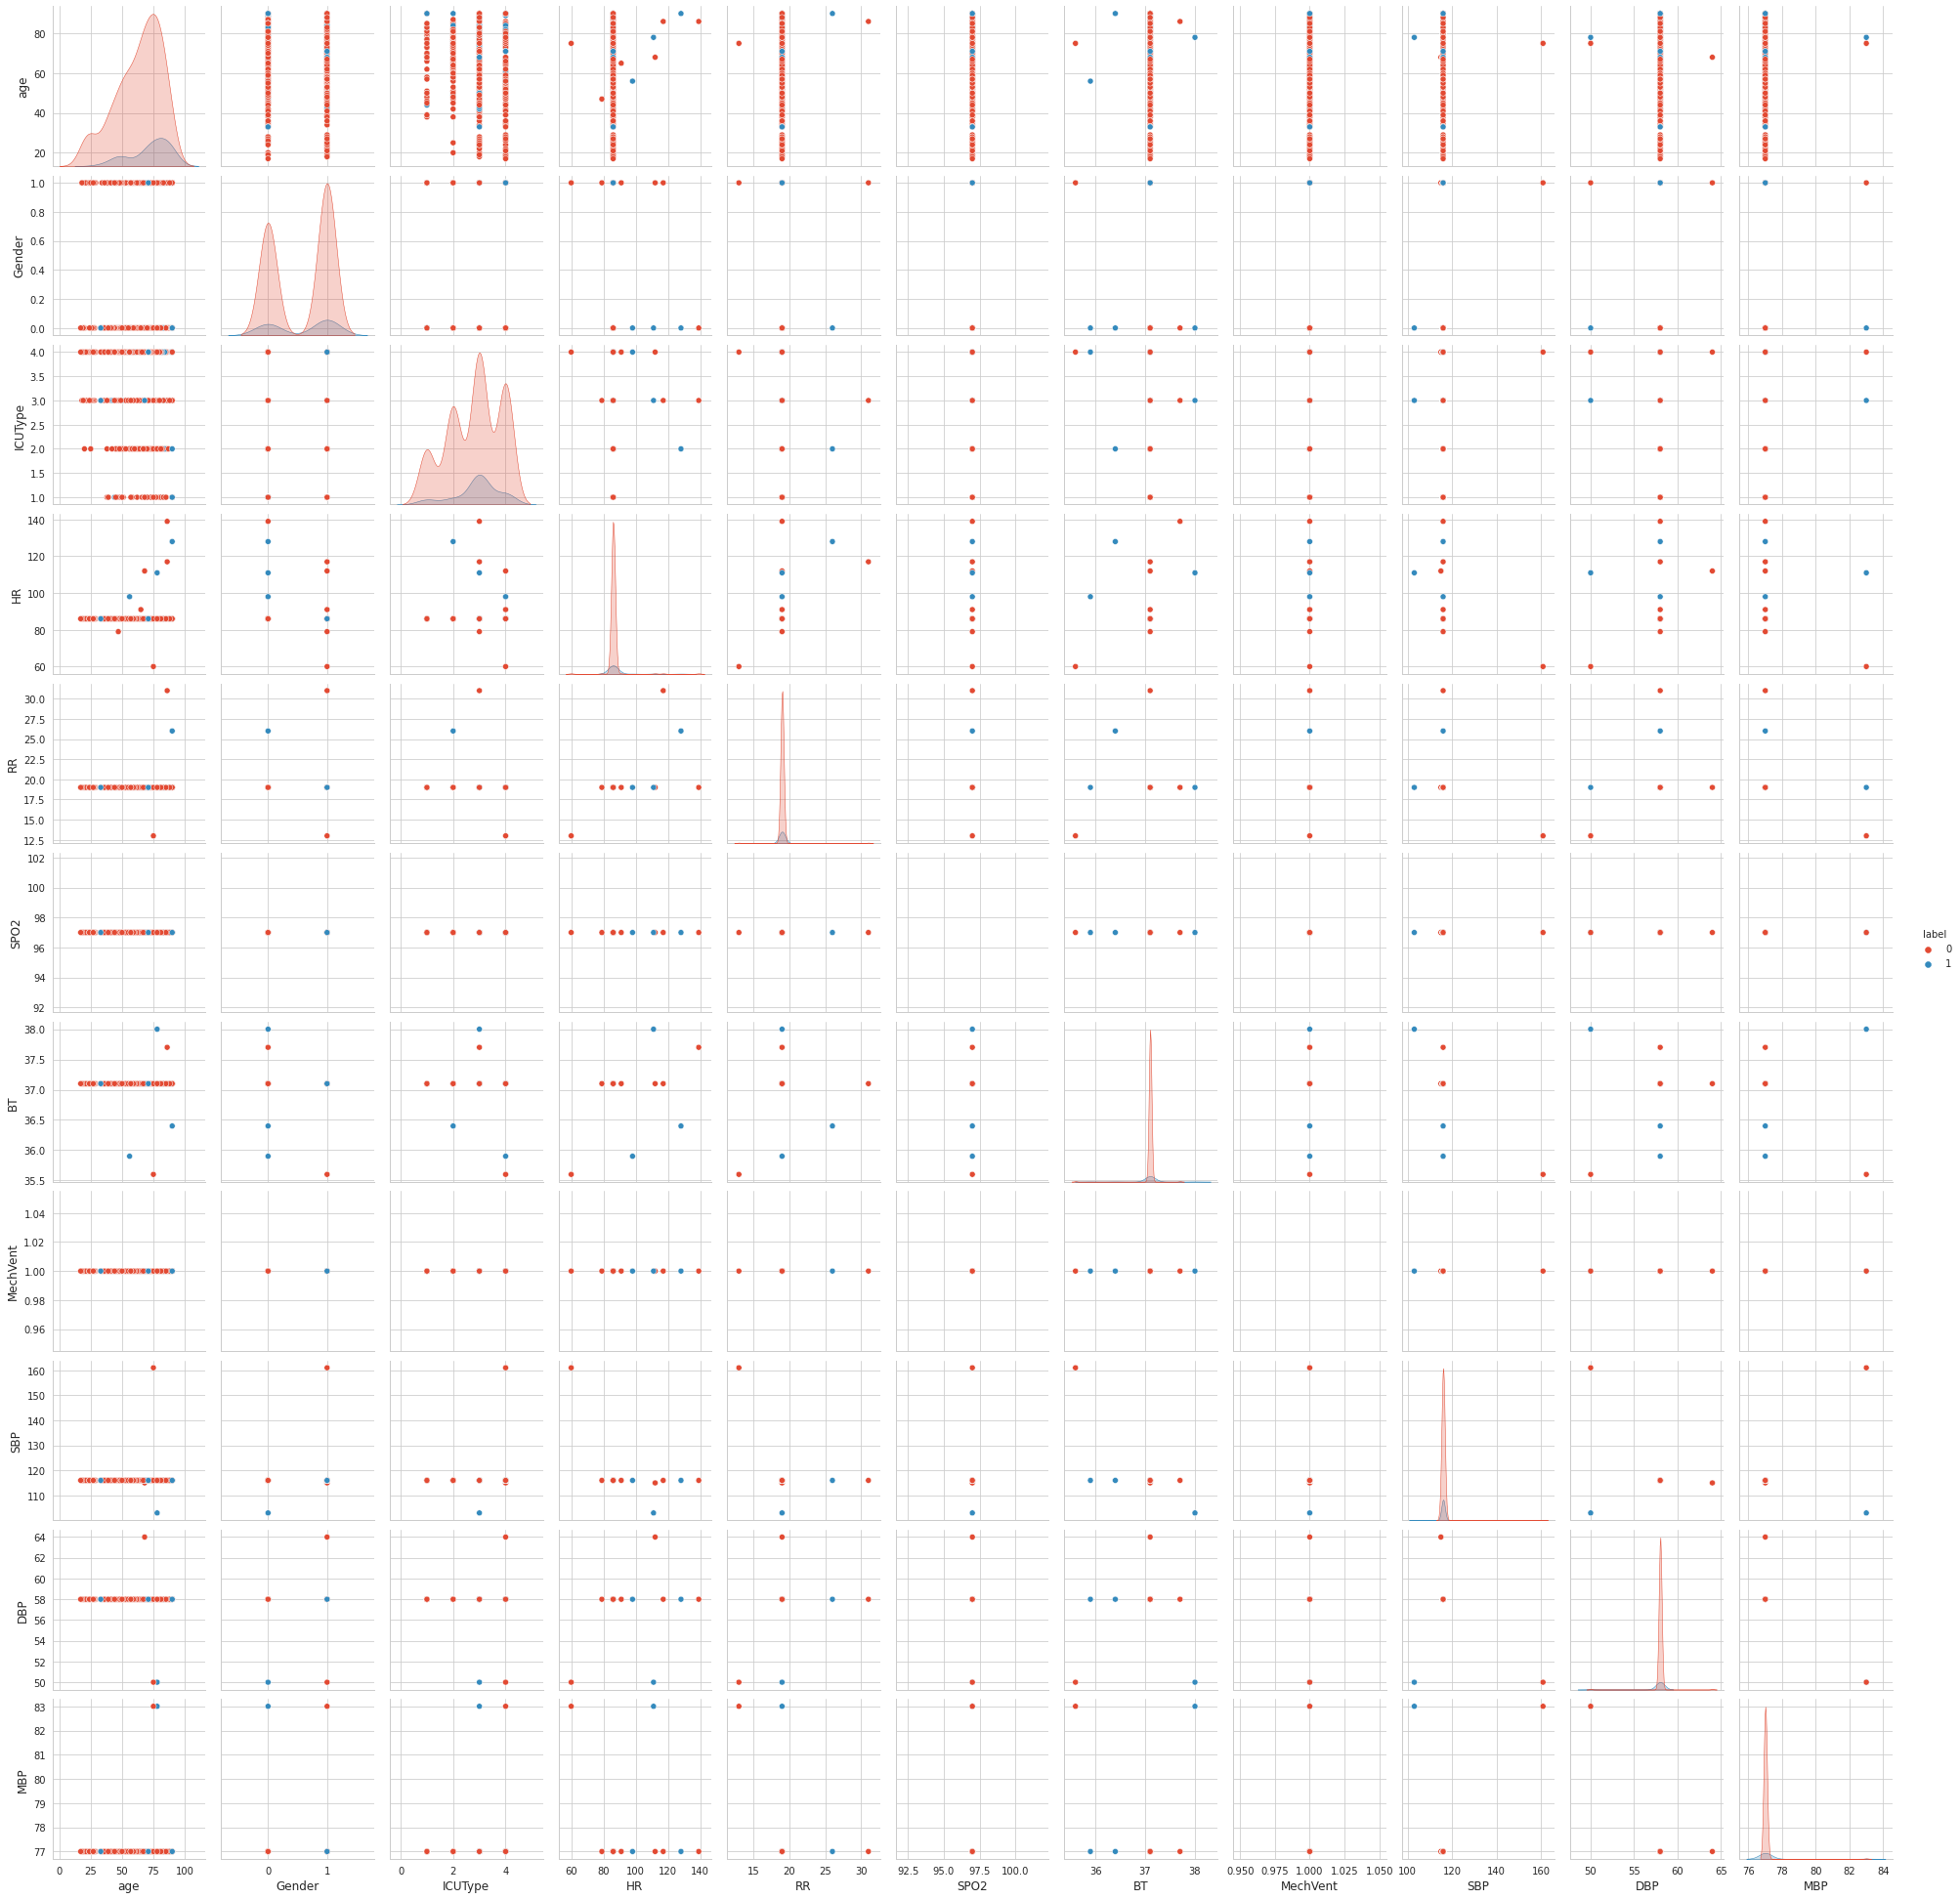

In [ ]:
fig = sns.pairplot(essential_df.drop(['pid'], axis=1), hue='label')

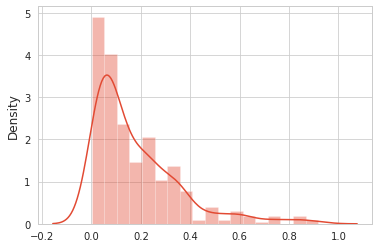

In [ ]:
sns.distplot(new_df['cnn4_pred'].values)

In [ ]:
loaded_cnn4_thresholds

array([1.9140958 , 0.91409576, 0.9033571 , 0.87988245, 0.8508601 ,
       0.8322059 , 0.83157665, 0.80392057, 0.77468324, 0.7596698 ,
       0.75643086, 0.7500442 , 0.73213404, 0.6440288 , 0.6057768 ,
       0.59466755, 0.5943301 , 0.5905735 , 0.5504732 , 0.5352285 ,
       0.53056043, 0.5294031 , 0.48554713, 0.48031643, 0.4597913 ,
       0.4588544 , 0.45214254, 0.44886717, 0.40875453, 0.4081141 ,
       0.39931548, 0.39856595, 0.39740843, 0.38558722, 0.33878568,
       0.33593652, 0.33579883, 0.33360347, 0.31844163, 0.31577492,
       0.29183733, 0.29025334, 0.2796962 , 0.27712116, 0.2623528 ,
       0.26145807, 0.24324395, 0.23958783, 0.23393631, 0.2333351 ,
       0.21833853, 0.21725318, 0.21042371, 0.2091492 , 0.20338842,
       0.20039982, 0.18608373, 0.18497   , 0.17634311, 0.17442353,
       0.16755292, 0.16695024, 0.1552217 , 0.152147  , 0.08011732,
       0.07971624, 0.07248132, 0.07178455, 0.07170057, 0.07121582,
       0.01362895], dtype=float32)

In [ ]:
loaded_cnn2_thresholds[loaded_cnn2_fpr > 0.8]

array([0.01362895], dtype=float32)

In [ ]:
loaded_cnn2_thresholds[(loaded_cnn2_tpr>0.9) & (loaded_cnn2_fpr>0.9)]

array([0.01362895], dtype=float32)

In [ ]:
loaded_cnn2_fpr, loaded_cnn2_tpr, loaded_cnn2_thresholds = roc_curve(test_y_3d, loaded_cnn2_pred)
loaded_cnn2_roc_auc = roc_auc_score(test_y_3d, loaded_cnn2_pred)


In [ ]:
cnn2_fpr, cnn2_tpr, cnn2_thresholds = roc_curve(test_)

# **못 맞춘 데이터 분석**

In [ ]:
from sklearn.metrics import roc_curve

## **ANN**

In [ ]:
ann_fpr, ann_tpr, ann_thresholds = roc_curve(data['label'], data['ann_pred'])

In [ ]:
max(ann_tpr-ann_fpr)

0.3947833775419982

In [ ]:
ann_cutoff = max(ann_tpr-ann_fpr)

In [ ]:
# pred
ann_pred = data['ann_pred']

# test_y
test_y = data['label']

In [ ]:
ann_pred_binary = np.where(ann_pred > ann_cutoff, 1, 0)
ann_pred_binary = pd.Series(ann_pred_binary)
ann_pred_binary

0      0
1      0
2      0
3      0
4      0
      ..
395    0
396    0
397    0
398    0
399    0
Length: 400, dtype: int64

In [ ]:
false_ann_pred = np.where(ann_pred_binary != test_y)
false_ann_pred  # 틀린 데이터 인덱스 추출(저장)

(array([  6,  14,  27,  36,  43,  44,  56,  62,  73,  85,  90,  98, 101,
        102, 114, 130, 140, 150, 156, 168, 171, 175, 190, 196, 203, 205,
        215, 216, 223, 226, 228, 239, 253, 255, 257, 263, 267, 270, 283,
        285, 293, 302, 306, 307, 308, 316, 322, 325, 328, 348, 352, 354,
        356, 358, 373, 378, 397]),)

In [ ]:
# 틀린 데이터들 (필수 컬럼)
ann_false_df = essential_df.loc[false_ann_pred]
ann_false_df

,pid,age,Gender,ICUType,HR,RR,SPO2,BT,MechVent,SBP,DBP,MBP,LOS,label
6,139045,90.0,0.0,1.0,68.0,19.0,97.0,36.2,1.0,116.0,58.0,77.0,5,1
14,133367,81.0,0.0,3.0,76.0,25.0,97.0,34.7,1.0,116.0,58.0,77.0,4,1
27,136282,38.0,1.0,3.0,98.0,19.0,91.0,37.7,1.0,107.0,69.0,78.0,36,0
36,136256,85.0,0.0,3.0,52.0,15.0,97.0,36.3,1.0,116.0,58.0,77.0,10,1
43,136897,49.0,1.0,2.0,56.0,19.0,95.0,37.0,1.0,154.0,71.0,92.0,13,1
44,135200,63.0,1.0,3.0,111.0,19.0,98.0,37.3,1.0,106.0,71.0,80.0,8,0
56,133064,50.0,1.0,3.0,86.0,19.0,97.0,35.7,1.0,116.0,58.0,77.0,11,1
62,135027,89.0,0.0,4.0,89.0,19.0,97.0,37.7,1.0,110.0,57.0,76.0,15,1
73,140339,70.0,1.0,3.0,86.0,19.0,98.0,37.2,1.0,189.0,123.0,143.0,24,1
85,139296,74.0,1.0,2.0,70.0,19.0,92.0,35.6,1.0,116.0,60.0,77.0,5,1


In [ ]:
# 생존인데 사망으로 예측
# 1으로 예측한 경우(실제는 0)
# Type1 Error
ann_false_positive = np.where((ann_pred_binary != test_y) & (ann_pred_binary == 1))
ann_fp_df = essential_df.loc[ann_false_positive]
ann_fp_df

,pid,age,Gender,ICUType,HR,RR,SPO2,BT,MechVent,SBP,DBP,MBP,LOS,label
27,136282,38.0,1.0,3.0,98.0,19.0,91.0,37.7,1.0,107.0,69.0,78.0,36,0
44,135200,63.0,1.0,3.0,111.0,19.0,98.0,37.3,1.0,106.0,71.0,80.0,8,0
130,136929,54.0,1.0,4.0,0.0,19.0,97.0,40.9,1.0,34.0,5.0,0.0,6,0
171,136972,80.0,0.0,4.0,80.0,19.0,99.0,36.9,1.0,150.0,56.0,87.0,14,0
228,139420,87.0,1.0,3.0,83.0,19.0,97.0,37.8,1.0,116.0,58.0,77.0,27,0
257,138728,77.0,1.0,3.0,76.0,19.0,100.0,37.6,1.0,104.0,56.0,70.0,24,0
263,141960,27.0,0.0,3.0,90.0,19.0,97.0,37.0,1.0,132.0,81.0,100.0,89,0
267,134193,89.0,1.0,3.0,71.0,12.0,97.0,35.8,1.0,116.0,58.0,77.0,3,0
270,137656,68.0,1.0,3.0,72.0,19.0,97.0,35.3,1.0,92.0,47.0,61.0,2,0
306,141236,33.0,0.0,4.0,108.0,19.0,97.0,37.1,1.0,121.0,58.0,80.0,20,0


In [ ]:
# 사망인데 생존으로 예측
# 0으로 예측한 경우(실제는 1)
# Type2 Error
ann_false_negative = np.where((ann_pred_binary != test_y) & (ann_pred_binary == 0))
ann_fn_df = essential_df.loc[ann_false_negative]
ann_fn_df

,pid,age,Gender,ICUType,HR,RR,SPO2,BT,MechVent,SBP,DBP,MBP,LOS,label
6,139045,90.0,0.0,1.0,68.0,19.0,97.0,36.2,1.0,116.0,58.0,77.0,5,1
14,133367,81.0,0.0,3.0,76.0,25.0,97.0,34.7,1.0,116.0,58.0,77.0,4,1
36,136256,85.0,0.0,3.0,52.0,15.0,97.0,36.3,1.0,116.0,58.0,77.0,10,1
43,136897,49.0,1.0,2.0,56.0,19.0,95.0,37.0,1.0,154.0,71.0,92.0,13,1
56,133064,50.0,1.0,3.0,86.0,19.0,97.0,35.7,1.0,116.0,58.0,77.0,11,1
62,135027,89.0,0.0,4.0,89.0,19.0,97.0,37.7,1.0,110.0,57.0,76.0,15,1
73,140339,70.0,1.0,3.0,86.0,19.0,98.0,37.2,1.0,189.0,123.0,143.0,24,1
85,139296,74.0,1.0,2.0,70.0,19.0,92.0,35.6,1.0,116.0,60.0,77.0,5,1
90,135973,90.0,1.0,3.0,126.0,27.0,97.0,36.1,1.0,116.0,58.0,77.0,7,1
98,134269,74.0,0.0,3.0,81.0,19.0,98.0,37.2,1.0,123.0,63.0,86.0,10,1


## **RNN**

In [ ]:
rnn_fpr, rnn_tpr, rnn_thresholds = roc_curve(data['label'], data['rnn1_pred'])

In [ ]:
max(rnn_tpr-rnn_fpr)

0.3872679045092838

In [ ]:
rnn_cutoff = max(rnn_tpr-rnn_fpr)

In [ ]:
# pred
rnn_pred = data['rnn1_pred']

# test_y
test_y = data['label']

In [ ]:
rnn_pred_binary = np.where(rnn_pred > rnn_cutoff, 1, 0)
rnn_pred_binary = pd.Series(rnn_pred_binary)
rnn_pred_binary

0      0
1      0
2      0
3      0
4      0
      ..
395    0
396    0
397    0
398    0
399    0
Length: 400, dtype: int64

In [ ]:
false_rnn_pred = np.where(rnn_pred_binary != test_y)
false_rnn_pred  # 틀린 데이터 인덱스 추출(저장)

(array([  6,  14,  35,  36,  43,  56,  62,  73,  81,  85,  90,  98, 101,
        102, 114, 118, 134, 140, 145, 150, 156, 168, 175, 190, 196, 202,
        203, 205, 215, 216, 223, 226, 239, 253, 255, 283, 285, 293, 300,
        302, 307, 308, 310, 315, 320, 322, 325, 348, 352, 356, 358, 378,
        387, 397]),)

In [ ]:
# 틀린 데이터들 (필수 컬럼)
rnn_false_df = essential_df.loc[false_rnn_pred]
rnn_false_df

,pid,age,Gender,ICUType,HR,RR,SPO2,BT,MechVent,SBP,DBP,MBP,LOS,label
6,139045,90.0,0.0,1.0,68.0,19.0,97.0,36.2,1.0,116.0,58.0,77.0,5,1
14,133367,81.0,0.0,3.0,76.0,25.0,97.0,34.7,1.0,116.0,58.0,77.0,4,1
35,134796,90.0,0.0,4.0,101.0,19.0,97.0,37.2,1.0,116.0,58.0,77.0,11,0
36,136256,85.0,0.0,3.0,52.0,15.0,97.0,36.3,1.0,116.0,58.0,77.0,10,1
43,136897,49.0,1.0,2.0,56.0,19.0,95.0,37.0,1.0,154.0,71.0,92.0,13,1
56,133064,50.0,1.0,3.0,86.0,19.0,97.0,35.7,1.0,116.0,58.0,77.0,11,1
62,135027,89.0,0.0,4.0,89.0,19.0,97.0,37.7,1.0,110.0,57.0,76.0,15,1
73,140339,70.0,1.0,3.0,86.0,19.0,98.0,37.2,1.0,189.0,123.0,143.0,24,1
81,139253,47.0,0.0,3.0,106.0,19.0,92.0,36.2,1.0,99.0,54.0,67.0,22,1
85,139296,74.0,1.0,2.0,70.0,19.0,92.0,35.6,1.0,116.0,60.0,77.0,5,1


In [ ]:
# 생존인데 사망으로 예측
# 1으로 예측한 경우(실제는 0)
# Type1 Error
rnn_false_positive = np.where((rnn_pred_binary != test_y) & (rnn_pred_binary == 1))
rnn_fp_df = essential_df.loc[rnn_false_positive]
rnn_fp_df

,pid,age,Gender,ICUType,HR,RR,SPO2,BT,MechVent,SBP,DBP,MBP,LOS,label
35,134796,90.0,0.0,4.0,101.0,19.0,97.0,37.2,1.0,116.0,58.0,77.0,11,0
320,133197,86.0,1.0,3.0,79.0,21.0,97.0,35.8,1.0,116.0,58.0,77.0,9,0


In [ ]:
# 사망인데 생존으로 예측
# 0으로 예측한 경우(실제는 1)
# Type2 Error
rnn_false_negative = np.where((rnn_pred_binary != test_y) & (rnn_pred_binary == 0))
rnn_fn_df = essential_df.loc[rnn_false_negative]
rnn_fn_df

,pid,age,Gender,ICUType,HR,RR,SPO2,BT,MechVent,SBP,DBP,MBP,LOS,label
6,139045,90.0,0.0,1.0,68.0,19.0,97.0,36.2,1.0,116.0,58.0,77.0,5,1
14,133367,81.0,0.0,3.0,76.0,25.0,97.0,34.7,1.0,116.0,58.0,77.0,4,1
36,136256,85.0,0.0,3.0,52.0,15.0,97.0,36.3,1.0,116.0,58.0,77.0,10,1
43,136897,49.0,1.0,2.0,56.0,19.0,95.0,37.0,1.0,154.0,71.0,92.0,13,1
56,133064,50.0,1.0,3.0,86.0,19.0,97.0,35.7,1.0,116.0,58.0,77.0,11,1
62,135027,89.0,0.0,4.0,89.0,19.0,97.0,37.7,1.0,110.0,57.0,76.0,15,1
73,140339,70.0,1.0,3.0,86.0,19.0,98.0,37.2,1.0,189.0,123.0,143.0,24,1
81,139253,47.0,0.0,3.0,106.0,19.0,92.0,36.2,1.0,99.0,54.0,67.0,22,1
85,139296,74.0,1.0,2.0,70.0,19.0,92.0,35.6,1.0,116.0,60.0,77.0,5,1
90,135973,90.0,1.0,3.0,126.0,27.0,97.0,36.1,1.0,116.0,58.0,77.0,7,1


## **LSTM**

In [ ]:
lstm_fpr, lstm_tpr, lstm_thresholds = roc_curve(data['label'], data['lstm1_pred'])

In [ ]:
max(lstm_tpr-lstm_fpr)

0.3819628647214854

In [ ]:
lstm_cutoff = max(lstm_tpr-lstm_fpr)

In [ ]:
# pred
lstm_pred = data['lstm1_pred']

# test_y
test_y = data['label']

In [ ]:
lstm_pred_binary = np.where(lstm_pred > lstm_cutoff, 1, 0)
lstm_pred_binary = pd.Series(lstm_pred_binary)
lstm_pred_binary

0      0
1      0
2      0
3      0
4      0
      ..
395    0
396    0
397    0
398    0
399    0
Length: 400, dtype: int64

In [ ]:
false_lstm_pred = np.where(lstm_pred_binary != test_y)
false_lstm_pred  # 틀린 데이터 인덱스 추출(저장)

(array([  6,  14,  36,  43,  56,  62,  73,  81,  85,  90,  98, 101, 102,
        114, 118, 134, 140, 145, 150, 156, 168, 175, 190, 196, 202, 203,
        205, 215, 216, 223, 226, 239, 253, 255, 283, 285, 293, 300, 302,
        307, 308, 310, 315, 322, 325, 348, 352, 356, 358, 378, 387, 397]),)

In [ ]:
# 틀린 데이터들 (필수 컬럼)
lstm_false_df = essential_df.loc[false_lstm_pred]
lstm_false_df

,pid,age,Gender,ICUType,HR,RR,SPO2,BT,MechVent,SBP,DBP,MBP,LOS,label
6,139045,90.0,0.0,1.0,68.0,19.0,97.0,36.2,1.0,116.0,58.0,77.0,5,1
14,133367,81.0,0.0,3.0,76.0,25.0,97.0,34.7,1.0,116.0,58.0,77.0,4,1
36,136256,85.0,0.0,3.0,52.0,15.0,97.0,36.3,1.0,116.0,58.0,77.0,10,1
43,136897,49.0,1.0,2.0,56.0,19.0,95.0,37.0,1.0,154.0,71.0,92.0,13,1
56,133064,50.0,1.0,3.0,86.0,19.0,97.0,35.7,1.0,116.0,58.0,77.0,11,1
62,135027,89.0,0.0,4.0,89.0,19.0,97.0,37.7,1.0,110.0,57.0,76.0,15,1
73,140339,70.0,1.0,3.0,86.0,19.0,98.0,37.2,1.0,189.0,123.0,143.0,24,1
81,139253,47.0,0.0,3.0,106.0,19.0,92.0,36.2,1.0,99.0,54.0,67.0,22,1
85,139296,74.0,1.0,2.0,70.0,19.0,92.0,35.6,1.0,116.0,60.0,77.0,5,1
90,135973,90.0,1.0,3.0,126.0,27.0,97.0,36.1,1.0,116.0,58.0,77.0,7,1


In [ ]:
# 생존인데 사망으로 예측
# 1으로 예측한 경우(실제는 0)
# Type1 Error
lstm_false_positive = np.where((lstm_pred_binary != test_y) & (lstm_pred_binary == 1))
lstm_fp_df = essential_df.loc[lstm_false_positive]
lstm_fp_df

,pid,age,Gender,ICUType,HR,RR,SPO2,BT,MechVent,SBP,DBP,MBP,LOS,label


In [ ]:
# 사망인데 생존으로 예측
# 0으로 예측한 경우(실제는 1)
# Type2 Error
lstm_false_negative = np.where((lstm_pred_binary != test_y) & (lstm_pred_binary == 0))
lstm_fn_df = essential_df.loc[lstm_false_negative]
lstm_fn_df

,pid,age,Gender,ICUType,HR,RR,SPO2,BT,MechVent,SBP,DBP,MBP,LOS,label
6,139045,90.0,0.0,1.0,68.0,19.0,97.0,36.2,1.0,116.0,58.0,77.0,5,1
14,133367,81.0,0.0,3.0,76.0,25.0,97.0,34.7,1.0,116.0,58.0,77.0,4,1
36,136256,85.0,0.0,3.0,52.0,15.0,97.0,36.3,1.0,116.0,58.0,77.0,10,1
43,136897,49.0,1.0,2.0,56.0,19.0,95.0,37.0,1.0,154.0,71.0,92.0,13,1
56,133064,50.0,1.0,3.0,86.0,19.0,97.0,35.7,1.0,116.0,58.0,77.0,11,1
62,135027,89.0,0.0,4.0,89.0,19.0,97.0,37.7,1.0,110.0,57.0,76.0,15,1
73,140339,70.0,1.0,3.0,86.0,19.0,98.0,37.2,1.0,189.0,123.0,143.0,24,1
81,139253,47.0,0.0,3.0,106.0,19.0,92.0,36.2,1.0,99.0,54.0,67.0,22,1
85,139296,74.0,1.0,2.0,70.0,19.0,92.0,35.6,1.0,116.0,60.0,77.0,5,1
90,135973,90.0,1.0,3.0,126.0,27.0,97.0,36.1,1.0,116.0,58.0,77.0,7,1


## **GRU**

In [ ]:
gru_fpr, gru_tpr, gru_thresholds = roc_curve(data['label'], data['gru1_pred'])

In [ ]:
max(gru_tpr-gru_fpr)

0.4299292661361627

In [ ]:
gru_cutoff = max(gru_tpr-gru_fpr)

In [ ]:
# pred
gru_pred = data['gru1_pred']

# test_y
test_y = data['label']

In [ ]:
gru_pred_binary = np.where(gru_pred > gru_cutoff, 1, 0)
gru_pred_binary = pd.Series(gru_pred_binary)
gru_pred_binary

0      0
1      1
2      0
3      0
4      0
      ..
395    0
396    0
397    0
398    0
399    0
Length: 400, dtype: int64

In [ ]:
false_gru_pred = np.where(gru_pred_binary != test_y)
false_gru_pred  # 틀린 데이터 인덱스 추출(저장)

(array([  1,   6,  14,  16,  35,  36,  43,  56,  69,  73,  81,  85,  90,
         98, 101, 102, 114, 118, 134, 140, 145, 150, 156, 168, 171, 175,
        181, 188, 190, 196, 202, 203, 205, 215, 216, 223, 226, 239, 253,
        283, 285, 288, 293, 300, 302, 307, 308, 310, 315, 322, 325, 348,
        352, 356, 358, 366, 378, 387, 397]),)

In [ ]:
# 틀린 데이터들 (필수 컬럼)
gru_false_df = essential_df.loc[false_gru_pred]
gru_false_df

,pid,age,Gender,ICUType,HR,RR,SPO2,BT,MechVent,SBP,DBP,MBP,LOS,label
1,142245,86.0,1.0,2.0,86.0,19.0,96.0,37.1,1.0,116.0,58.0,77.0,7,0
6,139045,90.0,0.0,1.0,68.0,19.0,97.0,36.2,1.0,116.0,58.0,77.0,5,1
14,133367,81.0,0.0,3.0,76.0,25.0,97.0,34.7,1.0,116.0,58.0,77.0,4,1
16,139385,20.0,0.0,2.0,86.0,19.0,97.0,37.1,1.0,116.0,58.0,77.0,3,0
35,134796,90.0,0.0,4.0,101.0,19.0,97.0,37.2,1.0,116.0,58.0,77.0,11,0
36,136256,85.0,0.0,3.0,52.0,15.0,97.0,36.3,1.0,116.0,58.0,77.0,10,1
43,136897,49.0,1.0,2.0,56.0,19.0,95.0,37.0,1.0,154.0,71.0,92.0,13,1
56,133064,50.0,1.0,3.0,86.0,19.0,97.0,35.7,1.0,116.0,58.0,77.0,11,1
69,137334,25.0,0.0,2.0,86.0,19.0,97.0,37.1,1.0,116.0,58.0,77.0,8,0
73,140339,70.0,1.0,3.0,86.0,19.0,98.0,37.2,1.0,189.0,123.0,143.0,24,1


In [ ]:
# 생존인데 사망으로 예측
# 1으로 예측한 경우(실제는 0)
# Type1 Error
gru_false_positive = np.where((gru_pred_binary != test_y) & (gru_pred_binary == 1))
gru_fp_df = essential_df.loc[gru_false_positive]
gru_fp_df

,pid,age,Gender,ICUType,HR,RR,SPO2,BT,MechVent,SBP,DBP,MBP,LOS,label
1,142245,86.0,1.0,2.0,86.0,19.0,96.0,37.1,1.0,116.0,58.0,77.0,7,0
16,139385,20.0,0.0,2.0,86.0,19.0,97.0,37.1,1.0,116.0,58.0,77.0,3,0
35,134796,90.0,0.0,4.0,101.0,19.0,97.0,37.2,1.0,116.0,58.0,77.0,11,0
69,137334,25.0,0.0,2.0,86.0,19.0,97.0,37.1,1.0,116.0,58.0,77.0,8,0
171,136972,80.0,0.0,4.0,80.0,19.0,99.0,36.9,1.0,150.0,56.0,87.0,14,0
181,135882,79.0,1.0,3.0,86.0,19.0,97.0,37.1,1.0,116.0,58.0,77.0,5,0
188,138269,42.0,0.0,3.0,86.0,19.0,97.0,37.1,1.0,116.0,58.0,77.0,79,0
288,141165,90.0,0.0,3.0,86.0,19.0,97.0,37.1,1.0,116.0,58.0,77.0,5,0
366,139838,56.0,0.0,4.0,83.0,19.0,97.0,37.3,1.0,93.0,52.0,66.0,-1,0


In [ ]:
# 사망인데 생존으로 예측
# 0으로 예측한 경우(실제는 1)
# Type2 Error
gru_false_negative = np.where((gru_pred_binary != test_y) & (gru_pred_binary == 0))
gru_fn_df = essential_df.loc[gru_false_negative]
gru_fn_df

,pid,age,Gender,ICUType,HR,RR,SPO2,BT,MechVent,SBP,DBP,MBP,LOS,label
6,139045,90.0,0.0,1.0,68.0,19.0,97.0,36.2,1.0,116.0,58.0,77.0,5,1
14,133367,81.0,0.0,3.0,76.0,25.0,97.0,34.7,1.0,116.0,58.0,77.0,4,1
36,136256,85.0,0.0,3.0,52.0,15.0,97.0,36.3,1.0,116.0,58.0,77.0,10,1
43,136897,49.0,1.0,2.0,56.0,19.0,95.0,37.0,1.0,154.0,71.0,92.0,13,1
56,133064,50.0,1.0,3.0,86.0,19.0,97.0,35.7,1.0,116.0,58.0,77.0,11,1
73,140339,70.0,1.0,3.0,86.0,19.0,98.0,37.2,1.0,189.0,123.0,143.0,24,1
81,139253,47.0,0.0,3.0,106.0,19.0,92.0,36.2,1.0,99.0,54.0,67.0,22,1
85,139296,74.0,1.0,2.0,70.0,19.0,92.0,35.6,1.0,116.0,60.0,77.0,5,1
90,135973,90.0,1.0,3.0,126.0,27.0,97.0,36.1,1.0,116.0,58.0,77.0,7,1
98,134269,74.0,0.0,3.0,81.0,19.0,98.0,37.2,1.0,123.0,63.0,86.0,10,1


## **CNN**

In [ ]:
cnn_fpr, cnn_tpr, cnn_thresholds = roc_curve(data['label'], data['cnn4_pred'])

In [ ]:
max(cnn_tpr - cnn_fpr)

0.4984526967285588

In [ ]:
cnn_cutoff = max(cnn_tpr - cnn_fpr)

In [ ]:
# pred
cnn_pred = data['cnn4_pred']

# test_y
test_y = data['label']

In [ ]:
cnn_pred_binary = np.where(cnn_pred > cnn_cutoff, 1, 0)
cnn_pred_binary = pd.Series(cnn_pred_binary)
cnn_pred_binary

0      0
1      0
2      0
3      0
4      0
      ..
395    0
396    0
397    0
398    0
399    0
Length: 400, dtype: int64

In [ ]:
false_cnn_pred = np.where(cnn_pred_binary != test_y)
false_cnn_pred  # 틀린 데이터 인덱스 추출(저장)

(array([  6,  14,  18,  35,  36,  43,  44,  56,  70,  73,  81,  85,  98,
        102, 114, 118, 130, 134, 145, 150, 156, 168, 171, 175, 176, 190,
        196, 203, 205, 207, 215, 216, 223, 226, 239, 243, 253, 257, 270,
        283, 285, 293, 300, 308, 310, 322, 325, 328, 348, 352, 354, 356,
        366, 373, 378, 397]),)

In [ ]:
# 틀린 데이터들 (필수 컬럼)
cnn_false_df = essential_df.loc[false_cnn_pred]
cnn_false_df

,pid,age,Gender,ICUType,HR,RR,SPO2,BT,MechVent,SBP,DBP,MBP,LOS,label
6,139045,90.0,0.0,1.0,68.0,19.0,97.0,36.2,1.0,116.0,58.0,77.0,5,1
14,133367,81.0,0.0,3.0,76.0,25.0,97.0,34.7,1.0,116.0,58.0,77.0,4,1
18,140821,72.0,1.0,3.0,102.0,19.0,99.0,38.0,1.0,124.0,54.0,77.0,22,0
35,134796,90.0,0.0,4.0,101.0,19.0,97.0,37.2,1.0,116.0,58.0,77.0,11,0
36,136256,85.0,0.0,3.0,52.0,15.0,97.0,36.3,1.0,116.0,58.0,77.0,10,1
43,136897,49.0,1.0,2.0,56.0,19.0,95.0,37.0,1.0,154.0,71.0,92.0,13,1
44,135200,63.0,1.0,3.0,111.0,19.0,98.0,37.3,1.0,106.0,71.0,80.0,8,0
56,133064,50.0,1.0,3.0,86.0,19.0,97.0,35.7,1.0,116.0,58.0,77.0,11,1
70,139192,88.0,0.0,3.0,84.0,19.0,98.0,37.4,1.0,112.0,73.0,85.0,10,0
73,140339,70.0,1.0,3.0,86.0,19.0,98.0,37.2,1.0,189.0,123.0,143.0,24,1


In [ ]:
# 생존인데 사망으로 예측
# 1으로 예측한 경우(실제는 0)
# Type1 Error
cnn_false_positive = np.where((cnn_pred_binary != test_y) & (cnn_pred_binary == 1))
cnn_fp_df = essential_df.loc[cnn_false_positive]
cnn_fp_df

,pid,age,Gender,ICUType,HR,RR,SPO2,BT,MechVent,SBP,DBP,MBP,LOS,label
18,140821,72.0,1.0,3.0,102.0,19.0,99.0,38.0,1.0,124.0,54.0,77.0,22,0
35,134796,90.0,0.0,4.0,101.0,19.0,97.0,37.2,1.0,116.0,58.0,77.0,11,0
44,135200,63.0,1.0,3.0,111.0,19.0,98.0,37.3,1.0,106.0,71.0,80.0,8,0
70,139192,88.0,0.0,3.0,84.0,19.0,98.0,37.4,1.0,112.0,73.0,85.0,10,0
130,136929,54.0,1.0,4.0,0.0,19.0,97.0,40.9,1.0,34.0,5.0,0.0,6,0
171,136972,80.0,0.0,4.0,80.0,19.0,99.0,36.9,1.0,150.0,56.0,87.0,14,0
176,140943,52.0,1.0,3.0,85.0,19.0,97.0,36.8,1.0,108.0,53.0,68.0,28,0
207,138726,79.0,1.0,3.0,135.0,13.0,97.0,37.2,1.0,116.0,58.0,77.0,3,0
243,137164,81.0,1.0,1.0,79.0,19.0,98.0,36.1,1.0,129.0,55.0,97.0,22,0
257,138728,77.0,1.0,3.0,76.0,19.0,100.0,37.6,1.0,104.0,56.0,70.0,24,0


In [ ]:
# 사망인데 생존으로 예측
# 0으로 예측한 경우(실제는 1)
# Type2 Error
cnn_false_negative = np.where((cnn_pred_binary != test_y) & (cnn_pred_binary == 0))
cnn_fn_df = essential_df.loc[cnn_false_negative]
cnn_fn_df

,pid,age,Gender,ICUType,HR,RR,SPO2,BT,MechVent,SBP,DBP,MBP,LOS,label
6,139045,90.0,0.0,1.0,68.0,19.0,97.0,36.2,1.0,116.0,58.0,77.0,5,1
14,133367,81.0,0.0,3.0,76.0,25.0,97.0,34.7,1.0,116.0,58.0,77.0,4,1
36,136256,85.0,0.0,3.0,52.0,15.0,97.0,36.3,1.0,116.0,58.0,77.0,10,1
43,136897,49.0,1.0,2.0,56.0,19.0,95.0,37.0,1.0,154.0,71.0,92.0,13,1
56,133064,50.0,1.0,3.0,86.0,19.0,97.0,35.7,1.0,116.0,58.0,77.0,11,1
73,140339,70.0,1.0,3.0,86.0,19.0,98.0,37.2,1.0,189.0,123.0,143.0,24,1
81,139253,47.0,0.0,3.0,106.0,19.0,92.0,36.2,1.0,99.0,54.0,67.0,22,1
85,139296,74.0,1.0,2.0,70.0,19.0,92.0,35.6,1.0,116.0,60.0,77.0,5,1
98,134269,74.0,0.0,3.0,81.0,19.0,98.0,37.2,1.0,123.0,63.0,86.0,10,1
102,133086,83.0,1.0,3.0,83.0,24.0,96.0,37.6,1.0,172.0,79.0,115.0,31,1


## **Functional API**

In [ ]:
func_fpr, func_tpr, func_thresholds = roc_curve(data['label'], data['func_pred'])

In [ ]:
max(func_tpr - func_fpr)

0.3994252873563218

In [ ]:
func_cutoff = max(func_tpr - func_fpr)

In [ ]:
# pred
func_pred = data['func_pred']

# test_y
test_y = data['label']

In [ ]:
func_pred_binary = np.where(func_pred > func_cutoff, 1, 0)
func_pred_binary = pd.Series(func_pred_binary)
func_pred_binary

0      0
1      0
2      0
3      0
4      0
      ..
395    0
396    0
397    0
398    0
399    0
Length: 400, dtype: int64

In [ ]:
false_func_pred = np.where(func_pred_binary != test_y)
false_func_pred  # 틀린 데이터 인덱스 추출(저장)

(array([  6,  14,  36,  43,  56,  62,  73,  81,  85,  90,  98, 101, 102,
        114, 118, 134, 140, 145, 150, 156, 168, 175, 190, 196, 202, 203,
        205, 215, 216, 223, 226, 239, 253, 255, 267, 283, 285, 293, 300,
        302, 307, 308, 310, 315, 322, 325, 348, 352, 356, 358, 378, 387,
        397]),)

In [ ]:
# 틀린 데이터들 (필수 컬럼)
func_false_df = essential_df.loc[false_func_pred]
func_false_df

,pid,age,Gender,ICUType,HR,RR,SPO2,BT,MechVent,SBP,DBP,MBP,LOS,label
6,139045,90.0,0.0,1.0,68.0,19.0,97.0,36.2,1.0,116.0,58.0,77.0,5,1
14,133367,81.0,0.0,3.0,76.0,25.0,97.0,34.7,1.0,116.0,58.0,77.0,4,1
36,136256,85.0,0.0,3.0,52.0,15.0,97.0,36.3,1.0,116.0,58.0,77.0,10,1
43,136897,49.0,1.0,2.0,56.0,19.0,95.0,37.0,1.0,154.0,71.0,92.0,13,1
56,133064,50.0,1.0,3.0,86.0,19.0,97.0,35.7,1.0,116.0,58.0,77.0,11,1
62,135027,89.0,0.0,4.0,89.0,19.0,97.0,37.7,1.0,110.0,57.0,76.0,15,1
73,140339,70.0,1.0,3.0,86.0,19.0,98.0,37.2,1.0,189.0,123.0,143.0,24,1
81,139253,47.0,0.0,3.0,106.0,19.0,92.0,36.2,1.0,99.0,54.0,67.0,22,1
85,139296,74.0,1.0,2.0,70.0,19.0,92.0,35.6,1.0,116.0,60.0,77.0,5,1
90,135973,90.0,1.0,3.0,126.0,27.0,97.0,36.1,1.0,116.0,58.0,77.0,7,1


In [ ]:
# 생존인데 사망으로 예측
# 1으로 예측한 경우(실제는 0)
# Type1 Error
func_false_positive = np.where((func_pred_binary != test_y) & (func_pred_binary == 1))
func_fp_df = essential_df.loc[func_false_positive]
func_fp_df

,pid,age,Gender,ICUType,HR,RR,SPO2,BT,MechVent,SBP,DBP,MBP,LOS,label
267,134193,89.0,1.0,3.0,71.0,12.0,97.0,35.8,1.0,116.0,58.0,77.0,3,0


In [ ]:
# 사망인데 생존으로 예측
# 0으로 예측한 경우(실제는 1)
# Type2 Error
func_false_negative = np.where((func_pred_binary != test_y) & (func_pred_binary == 0))
func_fn_df = essential_df.loc[func_false_negative]
func_fn_df

,pid,age,Gender,ICUType,HR,RR,SPO2,BT,MechVent,SBP,DBP,MBP,LOS,label
6,139045,90.0,0.0,1.0,68.0,19.0,97.0,36.2,1.0,116.0,58.0,77.0,5,1
14,133367,81.0,0.0,3.0,76.0,25.0,97.0,34.7,1.0,116.0,58.0,77.0,4,1
36,136256,85.0,0.0,3.0,52.0,15.0,97.0,36.3,1.0,116.0,58.0,77.0,10,1
43,136897,49.0,1.0,2.0,56.0,19.0,95.0,37.0,1.0,154.0,71.0,92.0,13,1
56,133064,50.0,1.0,3.0,86.0,19.0,97.0,35.7,1.0,116.0,58.0,77.0,11,1
62,135027,89.0,0.0,4.0,89.0,19.0,97.0,37.7,1.0,110.0,57.0,76.0,15,1
73,140339,70.0,1.0,3.0,86.0,19.0,98.0,37.2,1.0,189.0,123.0,143.0,24,1
81,139253,47.0,0.0,3.0,106.0,19.0,92.0,36.2,1.0,99.0,54.0,67.0,22,1
85,139296,74.0,1.0,2.0,70.0,19.0,92.0,35.6,1.0,116.0,60.0,77.0,5,1
90,135973,90.0,1.0,3.0,126.0,27.0,97.0,36.1,1.0,116.0,58.0,77.0,7,1


# **false data**

> False Positive<br>
False Negative

In [ ]:
# ann_fp_df, rnn_fp_df, lstm_fp_df, gru_fp_df, cnn_fp_df, func_fp_df
# ann_fn_df, rnn_fn_df, lstm_fn_df, gru_fn_df, cnn_fn_df, func_fn_df

fp_df_list = [ann_fp_df, rnn_fp_df, lstm_fp_df, gru_fp_df, cnn_fp_df, func_fp_df]
fn_df_list = [ann_fn_df, rnn_fn_df, lstm_fn_df, gru_fn_df, cnn_fn_df, func_fn_df]

fp_df_all = pd.concat(fp_df_list, ignore_index=True)
fn_df_all = pd.concat(fn_df_list, ignore_index=True)

fp_df_drop = fp_df_all.drop_duplicates('pid')
fn_df_drop = fn_df_all.drop_duplicates('pid')

In [ ]:
fp_df_drop

,pid,age,Gender,ICUType,HR,RR,SPO2,BT,MechVent,SBP,DBP,MBP,LOS,label
0,136282,38.0,1.0,3.0,98.0,19.0,91.0,37.7,1.0,107.0,69.0,78.0,36,0
1,135200,63.0,1.0,3.0,111.0,19.0,98.0,37.3,1.0,106.0,71.0,80.0,8,0
2,136929,54.0,1.0,4.0,0.0,19.0,97.0,40.9,1.0,34.0,5.0,0.0,6,0
3,136972,80.0,0.0,4.0,80.0,19.0,99.0,36.9,1.0,150.0,56.0,87.0,14,0
4,139420,87.0,1.0,3.0,83.0,19.0,97.0,37.8,1.0,116.0,58.0,77.0,27,0
5,138728,77.0,1.0,3.0,76.0,19.0,100.0,37.6,1.0,104.0,56.0,70.0,24,0
6,141960,27.0,0.0,3.0,90.0,19.0,97.0,37.0,1.0,132.0,81.0,100.0,89,0
7,134193,89.0,1.0,3.0,71.0,12.0,97.0,35.8,1.0,116.0,58.0,77.0,3,0
8,137656,68.0,1.0,3.0,72.0,19.0,97.0,35.3,1.0,92.0,47.0,61.0,2,0
9,141236,33.0,0.0,4.0,108.0,19.0,97.0,37.1,1.0,121.0,58.0,80.0,20,0


In [ ]:
fn_df_drop

,pid,age,Gender,ICUType,HR,RR,SPO2,BT,MechVent,SBP,DBP,MBP,LOS,label
0,139045,90.0,0.0,1.0,68.0,19.0,97.0,36.2,1.0,116.0,58.0,77.0,5,1
1,133367,81.0,0.0,3.0,76.0,25.0,97.0,34.7,1.0,116.0,58.0,77.0,4,1
2,136256,85.0,0.0,3.0,52.0,15.0,97.0,36.3,1.0,116.0,58.0,77.0,10,1
3,136897,49.0,1.0,2.0,56.0,19.0,95.0,37.0,1.0,154.0,71.0,92.0,13,1
4,133064,50.0,1.0,3.0,86.0,19.0,97.0,35.7,1.0,116.0,58.0,77.0,11,1
5,135027,89.0,0.0,4.0,89.0,19.0,97.0,37.7,1.0,110.0,57.0,76.0,15,1
6,140339,70.0,1.0,3.0,86.0,19.0,98.0,37.2,1.0,189.0,123.0,143.0,24,1
7,139296,74.0,1.0,2.0,70.0,19.0,92.0,35.6,1.0,116.0,60.0,77.0,5,1
8,135973,90.0,1.0,3.0,126.0,27.0,97.0,36.1,1.0,116.0,58.0,77.0,7,1
9,134269,74.0,0.0,3.0,81.0,19.0,98.0,37.2,1.0,123.0,63.0,86.0,10,1


In [ ]:
overlap_fp = fp_df_all[fp_df_all.duplicated()==True]
overlap_fp

,pid,age,Gender,ICUType,HR,RR,SPO2,BT,MechVent,SBP,DBP,MBP,LOS,label
18,134796,90.0,0.0,4.0,101.0,19.0,97.0,37.2,1.0,116.0,58.0,77.0,11,0
20,136972,80.0,0.0,4.0,80.0,19.0,99.0,36.9,1.0,150.0,56.0,87.0,14,0
26,134796,90.0,0.0,4.0,101.0,19.0,97.0,37.2,1.0,116.0,58.0,77.0,11,0
27,135200,63.0,1.0,3.0,111.0,19.0,98.0,37.3,1.0,106.0,71.0,80.0,8,0
29,136929,54.0,1.0,4.0,0.0,19.0,97.0,40.9,1.0,34.0,5.0,0.0,6,0
30,136972,80.0,0.0,4.0,80.0,19.0,99.0,36.9,1.0,150.0,56.0,87.0,14,0
34,138728,77.0,1.0,3.0,76.0,19.0,100.0,37.6,1.0,104.0,56.0,70.0,24,0
35,137656,68.0,1.0,3.0,72.0,19.0,97.0,35.3,1.0,92.0,47.0,61.0,2,0
36,138499,88.0,1.0,3.0,99.0,19.0,97.0,36.8,1.0,116.0,58.0,77.0,15,0
37,135291,62.0,1.0,3.0,78.0,19.0,97.0,36.8,1.0,145.0,64.0,90.0,13,0


In [ ]:
overlap_fp.to_csv('/content/drive/MyDrive/최종프로젝트/overlap_fp_data.csv')

In [ ]:
overlap_fn = fn_df_all[fn_df_all.duplicated()==True]
overlap_fn

,pid,age,Gender,ICUType,HR,RR,SPO2,BT,MechVent,SBP,DBP,MBP,LOS,label
43,139045,90.0,0.0,1.0,68.0,19.0,97.0,36.2,1.0,116.0,58.0,77.0,5,1
44,133367,81.0,0.0,3.0,76.0,25.0,97.0,34.7,1.0,116.0,58.0,77.0,4,1
45,136256,85.0,0.0,3.0,52.0,15.0,97.0,36.3,1.0,116.0,58.0,77.0,10,1
46,136897,49.0,1.0,2.0,56.0,19.0,95.0,37.0,1.0,154.0,71.0,92.0,13,1
47,133064,50.0,1.0,3.0,86.0,19.0,97.0,35.7,1.0,116.0,58.0,77.0,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,133390,79.0,0.0,3.0,82.0,19.0,97.0,38.4,1.0,116.0,58.0,77.0,6,1
286,141808,56.0,0.0,4.0,112.0,19.0,97.0,37.3,1.0,119.0,64.0,85.0,4,1
287,139418,33.0,0.0,3.0,92.0,19.0,94.0,39.4,1.0,104.0,53.0,68.0,15,1
288,137325,68.0,1.0,3.0,119.0,19.0,97.0,37.4,1.0,90.0,51.0,64.0,53,1


In [ ]:
overlap_fn.to_csv('/content/drive/MyDrive/최종프로젝트/overlap_fn_data.csv')

In [ ]:
overlap_fp['pid'].unique()

array([134796, 136972, 135200, 136929, 138728, 137656, 138499, 135291,
       139838, 140116, 134193])

In [ ]:
overlap_fn['pid'].unique()

array([139045, 133367, 136256, 136897, 133064, 135027, 140339, 139296,
       135973, 134269, 138964, 133086, 134759, 138436, 137657, 140235,
       132551, 133525, 141368, 139641, 138863, 140344, 136912, 135307,
       135992, 135944, 134493, 140730, 140413, 142391, 135009, 133166,
       134475, 138409, 137154, 135404, 132598, 133636, 142353, 133390,
       141808, 139418, 139358, 139253, 139197, 138514, 140677, 135465,
       133708, 132979, 135971, 137325])